In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
import mne_connectivity
from mne_connectivity import phase_slope_index, seed_target_indices, spectral_connectivity_epochs
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import fooof
# Import plotting functions
from fooof.plts.spectra import plot_spectrum, plot_spectra
# Import the FOOOF object
from fooof import FOOOF
from fooof import FOOOFGroup
import os 
import joblib
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import warnings 

# I only want to see warnings once
warnings.filterwarnings('ignore')

from joblib import delayed, Parallel
from statsmodels.stats import multitest

Note: If you have installed this package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [3]:
import sys
sys.path.append('/hpc/users/qasims01/resources/LFPAnalysis')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils, oscillation_utils, statistics_utils


In [5]:
import h5io

## First, get the behavior data

This is from another notebook with a kernel and environment specifically for beahvior

note to seld: YOU MUST RUN EMU_BEHAV.ipynb BEFORE TO MAKE SURE YOU'VE PROCESSED ALL BEHAVIORS

In [6]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results
load_dir = f'{base_dir}/work/qasims01/MemoryBanditData/EMU'

# Load the demographics data to get information about who has run the task
demo_file = f'{base_dir}/projects/guLab/Salman/EMU/MemoryBanditsDatabase.xlsx'
demo_data = pd.read_excel(demo_file, engine='openpyxl')
subj_df = demo_data[(demo_data.LongVersion==1) & (demo_data.Minerva==1)]

# Let's get rid of Iowa patients for now 

# subj_df = subj_df[subj_df.Site!='UI']
# subj_df = subj_df[subj_df.MSSMCode=='MS028']
subj_df = subj_df[~subj_df['MSSMCode'].isin(['MS015', 'MS024', 'MS034', 'MS038'])]


days = ['Day1', 'Day2']
subj_ids = subj_df.MSSMCode.values
subj_formats = subj_df.format.values
subj_sites = subj_df.Site.values
subj_days = subj_df.Day2.values

In [7]:
subj_df

Site MSSMCode OtherCodes  Day1  Day2  LongVersion      Date1  \
3   MSSM    MS012        NaN   1.0   0.0          1.0 2022-08-10   
4     UI    UI001        640   1.0   1.0          1.0 2022-09-19   
6   MSSM    MS016        NaN   1.0   1.0          1.0 2022-09-24   
7   MSSM    MS017        NaN   1.0   1.0          1.0 2022-10-05   
8     UI    UI002        666   1.0   1.0          1.0 2022-11-10   
9   MSSM    MS019        NaN   1.0   1.0          1.0 2022-12-01   
10  MSSM    MS020        NaN   1.0   1.0          1.0 2023-02-02   
11  MSSM    MS022        NaN   1.0   0.0          1.0 2023-02-05   
12  MSSM    MS023        NaN   1.0   1.0          1.0 2023-02-21   
13    UI    UI003        672   1.0   0.0          1.0 2023-02-28   
15  MSSM    MS025        NaN   1.0   1.0          1.0 2023-03-09   
16  MSSM    MS026        NaN   1.0   1.0          1.0 2023-03-23   
17  MSSM    MS028        NaN   1.0   0.0          1.0 2023-04-05   
18  MSSM    MS030        NaN   1.0   1.0          1.0 2023-06-07   
19    UI    UI004        702   1.0   0.0          1.0 2023-06-29   
22  MSSM    MS035        NaN   1.0   1.0          1.0        NaT   
23  MSSM    MS036        NaN   1.0   1.0          1.0 2023-08-16   
27    UI    UI006        728   1.0   1.0          1.0 2023-12-12   
29    UI    UI007        741   1.0   1.0          1.0 2024-01-31   

          Experimenter  Micros  Resp  ...   Age   BDI   BAI  IQ (TOPF)  \
3              Lizbeth     0.0   0.0  ...  20.0   NaN   NaN        NaN   
4         Ariane Rhone     NaN   1.0  ...  45.0   NaN   NaN        NaN   
6     Salman + Lizbeth     0.0   0.0  ...  24.0   1.0   0.0       38.0   
7     Salman + Lizbeth     0.0   0.0  ...  26.0  22.0  29.0       55.0   
8         Ariane Rhone     0.0   1.0  ...  10.0   NaN   NaN        NaN   
9              Lizbeth     0.0   0.0  ...  56.0  23.0  13.0       27.0   
10             Lizbeth     1.0   0.0  ...  31.0  24.0  14.0       28.0   
11    Lizbeth + Jackie     1.0   0.0  ...  65.0  10.0  12.0       57.0   
12             Lizbeth     0.0   0.0  ...  52.0   6.0   4.0       27.0   
13        Ariane Rhone     1.0   1.0  ...  36.0   NaN   NaN        NaN   
15  Christina + Jackie     1.0   0.0  ...  38.0   3.0  10.0       58.0   
16              Salman     1.0   1.0  ...  49.0  18.0  30.0       33.0   
17             Lizbeth     1.0   0.0  ...  32.0   2.0  12.0       37.0   
18             Lizbeth     1.0   0.0  ...  67.0   NaN   NaN        NaN   
19        Ariane Rhone     0.0   1.0  ...  22.0   NaN   NaN        NaN   
22             Lizbeth     0.0   0.0  ...  53.0  17.0  14.0       21.0   
23             Lizbeth     0.0   0.0  ...  17.0   9.0   6.0       23.0   
27        Ariane Rhone     1.0   1.0  ...   NaN   NaN   NaN        NaN   
29        Ariane Rhone     1.0   1.0  ...   NaN   NaN   NaN        NaN   

   Education  Handedness  Sex              Race       Ethnicity  Notes.1  
3        NaN           R   F              White    Not Hispanic      NaN  
4        NaN           R    F               NaN             NaN      NaN  
6        NaN           R    F          Hispanic        Hispanic      NaN  
7        NaN           R    F             Other  Latin-American      NaN  
8        NaN           L    M               NaN             NaN      NaN  
9        NaN           R    M             White    Puerto Rican      NaN  
10       NaN           R    F          Jamaican    Not Hispanic      NaN  
11       NaN           R    M             White    Not Hispanic      NaN  
12       NaN           R    M             Other    Not Hispanic      NaN  
13       NaN           R    F               NaN             NaN      NaN  
15       NaN           R    F             White    Not Hispanic      NaN  
16       NaN           R    F            White     Puerto Rican      NaN  
17       NaN         NaN    F  African-American    Not Hispanic      NaN  
18       NaN           R    F             White    Not Hispanic      NaN  
19       NaN           R    M        

In [8]:
# load behavioral data
learn_df = pd.read_csv(f'{load_dir}/learn_df.csv')
combined_df = pd.read_csv(f'{load_dir}/combined_df.csv')

# Filter just to the participants in this notebook
learn_df = learn_df[learn_df.participant.isin(subj_ids)]
combined_df = combined_df[combined_df.participant.isin(subj_ids)]


# I enter the day information in stupidly 
combined_df.condition = combined_df.condition.apply(lambda x: 'Day1' if x=='day_1' else 'Day2' if x=='day_2' else np.nan)
# 'None's are kind of screwing things up a bit for me because I can't get a time from them (MS038). 
combined_df['recog_time'] = combined_df['recog_time'].apply(lambda x: float(x) if (~pd.isna(x)) & (x!='None') else np.nan)
# 
combined_df['baseline_start_mem'] = combined_df['baseline_start_mem'].apply(lambda x: float(x) if (~pd.isna(x)) & (x!='None') else np.nan)

# add RPE to the combined df dataframe: 

combined_df['rpe'] = np.nan
for ix, row in learn_df.iterrows():
    combined_df.loc[(combined_df.img_path==row.img_path) & (combined_df.participant==row.participant), 'rpe'] = row.rpe

## Load, pre-process and re-reference the neural data

Run the initial loading and pre-processing

In [ ]:
for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    for day in days:
        # Check if this day is in the dataset:
        if subj_df[subj_df.MSSMCode==subj_id][day].values[0] == 0:
            print (f'subject {subj_id} does not have Day 2 data')
            continue
        else:
            print(f'Working on subj {subj_id}')
            # Set paths
            load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
            elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
            save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
            # Check if path exists for saving, and if not, make it
            if not os.path.exists(save_path):
                os.makedirs(save_path)

            # electrode files could either be csv or excel
            elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
            # There should really only be one, so grab it with the zero-index 
            elec_file = elec_files[0]

            # Make MNE file
            mne_data = lfp_preprocess_utils.make_mne(load_path=load_path, 
                                                     elec_path=elec_file,
                                                     format=format,
                                                     return_data=True,
                                                     site=site, 
                                                     check_bad=False) # changed this to not annotate anything as bad 
            
            # Save this data so that you don't need this step again:
            mne_data.save(f'{save_path}/raw_ieeg.fif', overwrite=True)


Update 4/09/2024: I'm revising my thinking on manual selection of bad channels prior to reference. While this is GENERALLY a good idea, the EEG techs use a bipolar reference while doing real-time optimization of the signal for clinical purposes. So we typically know the unperturbed bipolar montage largely looks good, most of the time. Let's only manually look for bad data after bipolar referencing.

Even though the pipeline automatically detects channels with high variance compared to the rest of the data, it can still be very useful to scroll through the data and manually click on channels that are bad (or click on automatically bad channels that are,in fact, not bad). 

Feel free to be liberal with this. Bad channels are not omitted from analysis; they are simply omitted from being used as references, so they don't spread the 'badness' to other channels.

Manually annotate bad channels for each recording: 

In [13]:
%matplotlib notebook 
# Note: this does not work in JupyterLAB. Must be done int Jupyter Notebook. 

Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day1/raw_ieeg.fif...
Isotrak not found
    Range : 0 ... 446780 =      0.000 ...   893.560 secs
Ready.
Reading 0 ... 446780  =      0.000 ...   893.560 secs...


<IPython.core.display.Javascript object>


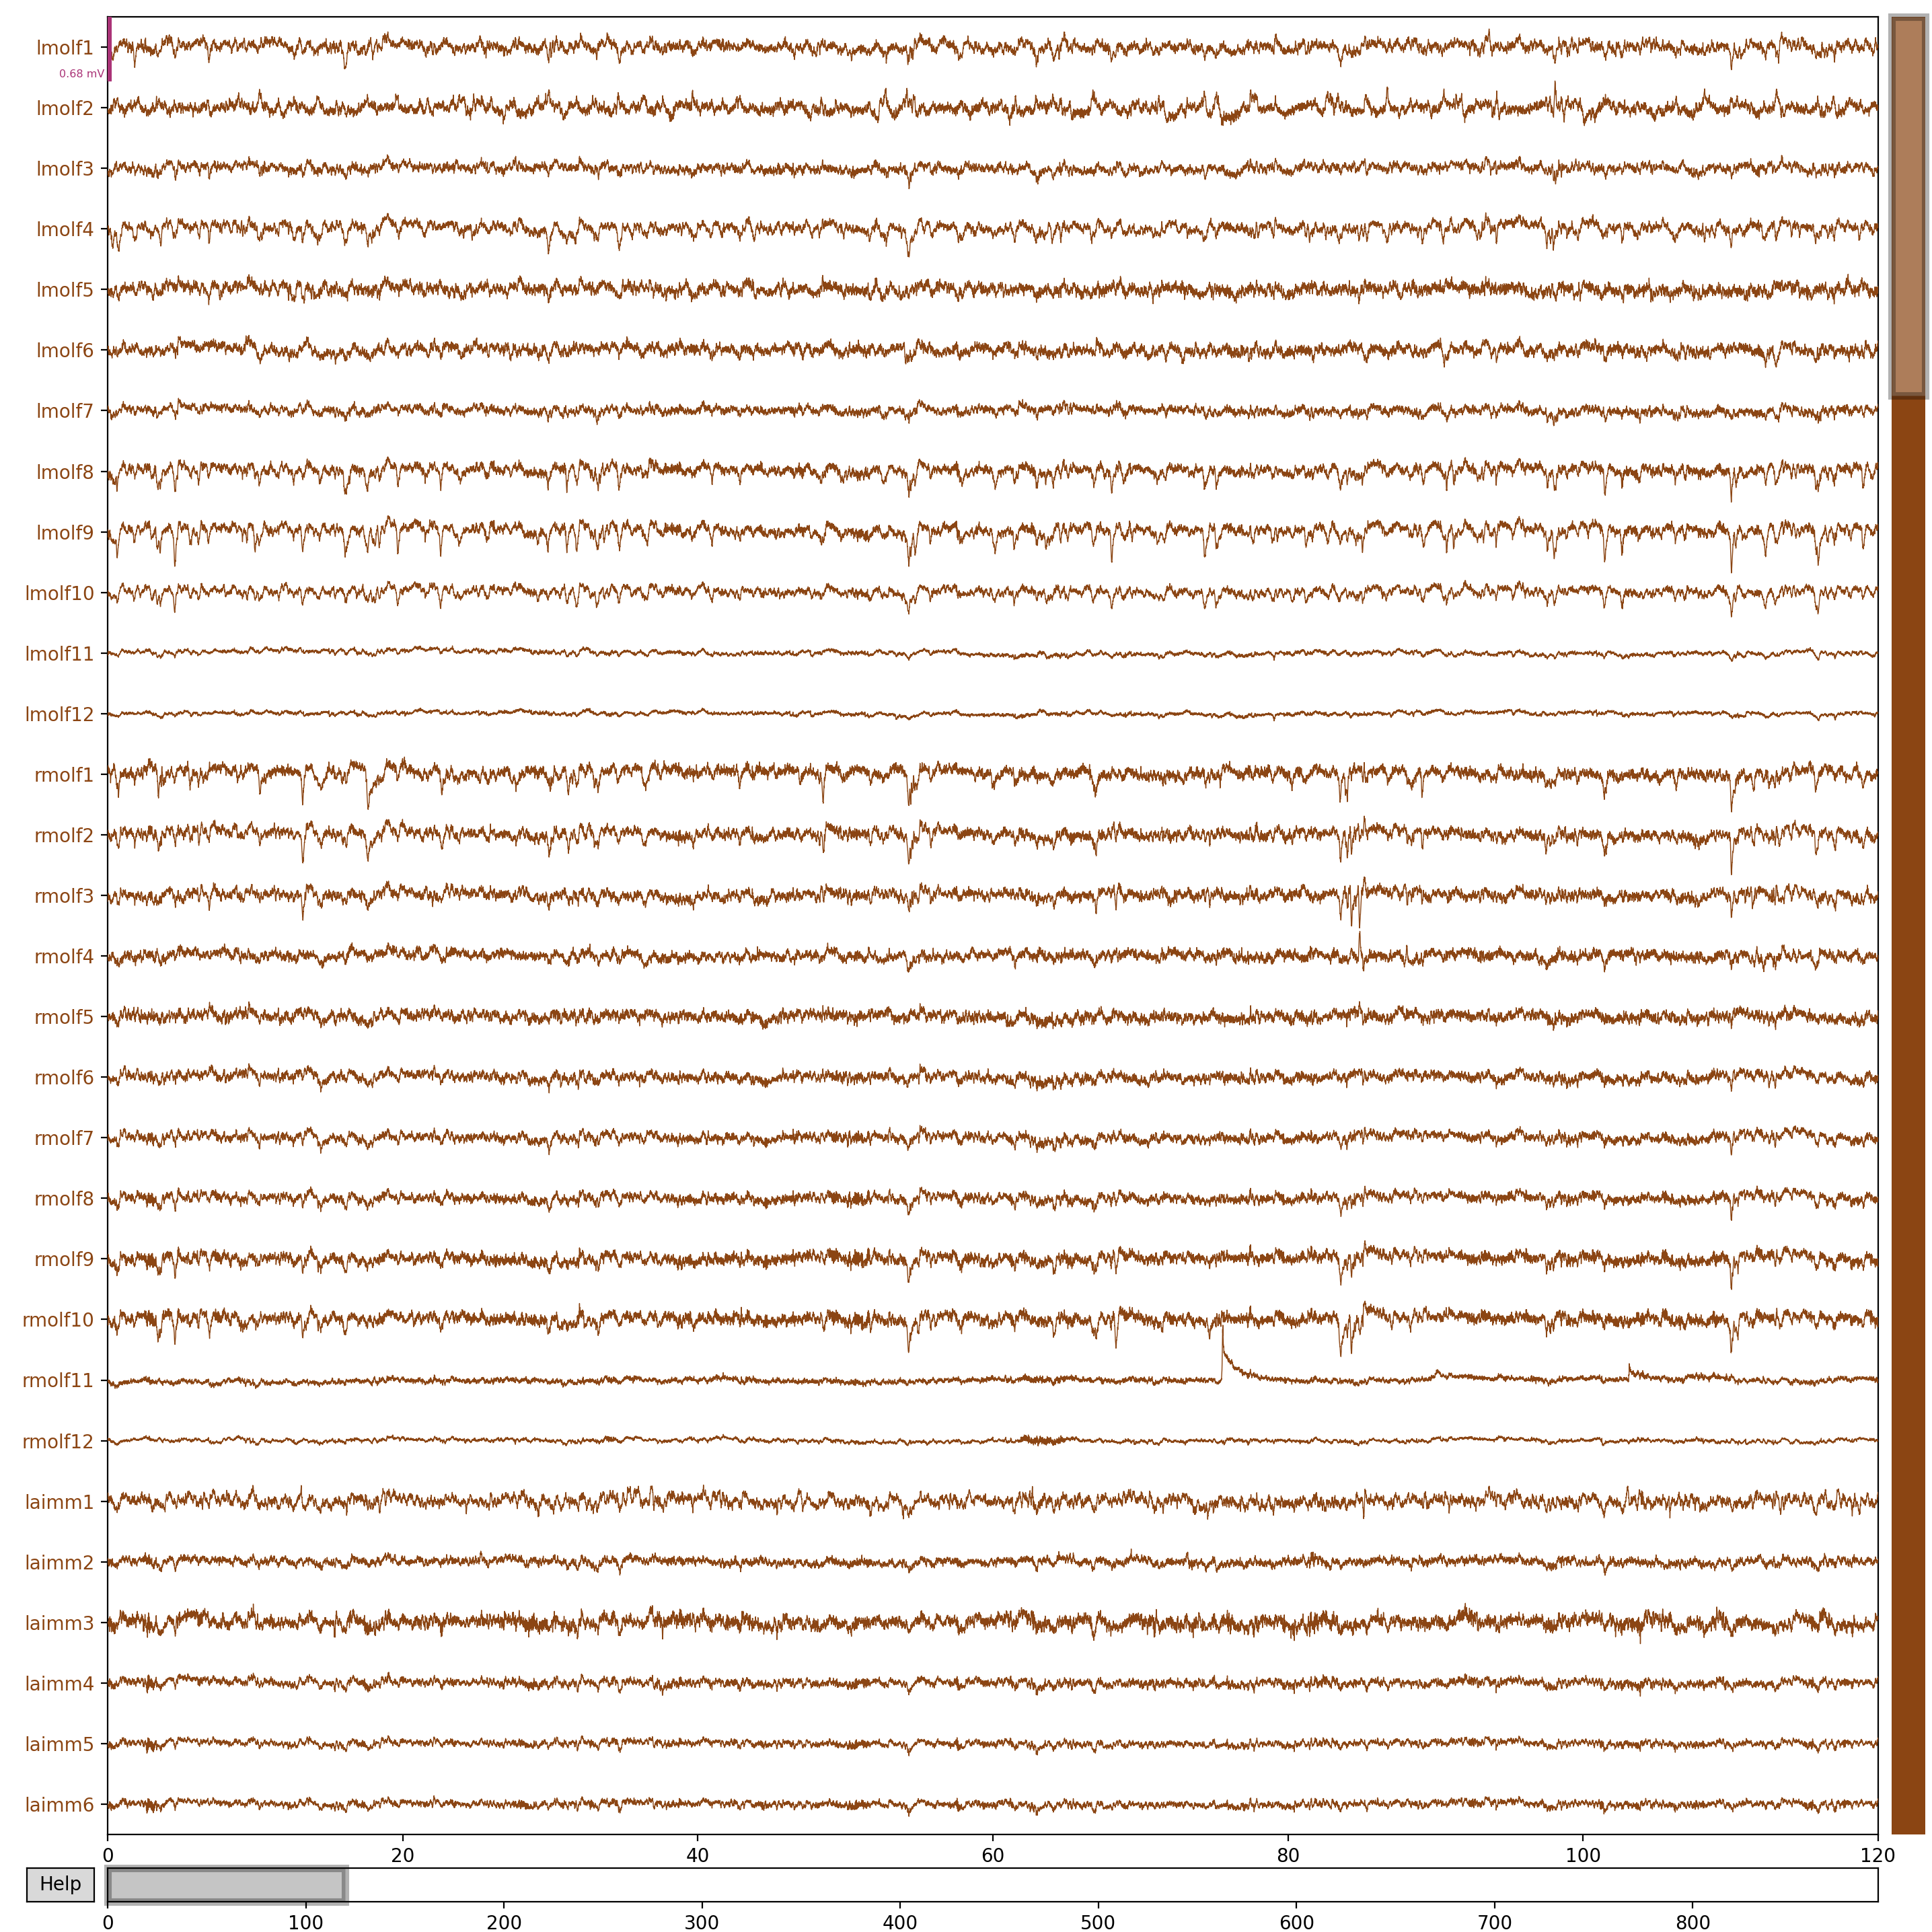

In [53]:
subj_id = 'MS036'
day = 'Day1'
save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
mne_data = mne.io.read_raw_fif(f'{save_path}/raw_ieeg.fif', preload=True)
fig = mne_data.plot(start=0, duration=120, n_channels=30, 
                      scalings=mne_data._data.max()/30
                     )

In [16]:
# Save this manual data
mne_data.save(f'{save_path}/raw_ieeg.fif', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/neural/Day1/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/neural/Day1/raw_ieeg.fif
[done]


## Re-reference

In general, I prefer to do bipolar referencing. I still see good high-frequency activity when doing so. However, you can also do white matter referencing. 

In [54]:
for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    for day in days:
        # Check if this day is in the dataset:
        if subj_df[day].values[ix] == 0:
            print (f'subject {subj_id} does not have Day 2 data')
            continue
        else:
            print(f'Working on subj {subj_id}')
            # Set paths
            load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
            elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
            save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
            # Check if path exists for saving, and if not, make it
            if not os.path.exists(save_path):
                os.makedirs(save_path)

            # electrode files could either be csv or excel
            elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
            # There should really only be one, so grab it with the zero-index 
            elec_file = elec_files[0]

            # Make MNE file
            mne_data = mne.io.read_raw_fif(f'{save_path}/raw_ieeg.fif', preload=True)


            # Re-reference neural data
            mne_data_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                                          elec_path=elec_file, 
                                                          method='bipolar', 
                                                          site=site)

#             # Save this data so that you don't need this step again:
            mne_data_reref.save(f'{save_path}/bp_ref_ieeg.fif', overwrite=True)
            
            # Should also save out re-referenced elec_file: 
            # Weird issue to note: reference montage could change across days if a new channel becomes noisy (or a noisy channel cleans up!) 

            elec_df = lfp_preprocess_utils.rename_elec_df_reref(mne_data_reref.ch_names, elec_file, site=site)

            # add region to the data frame 
            if site == 'MSSM':
                manual_col = [col for col in elec_df.columns if 'manual' in col.lower()][0]
                all_regions = [] 
                for chan_name in elec_df.label.unique():
                    elec_region = analysis_utils.select_rois_picks(elec_df, chan_name, manual_col=manual_col)
                    all_regions.append(elec_region) 

                elec_df['salman_region'] = all_regions
                elec_df['hemisphere'] = elec_df.label.apply(lambda x: x[0])

            elec_df.to_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/{day}_reref_elec_df', index=False)
            

Working on subj MS012
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/raw_ieeg.fif...
Isotrak not found
    Range : 0 ... 394061 =      0.000 ...   788.122 secs
Ready.
Reading 0 ... 394061  =      0.000 ...   788.122 secs...
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=60, n_times=394062
    Range : 0 ... 394061 =      0.000 ...   788.122 secs
Ready.
Added the following bipolar channels:
racas1-racas2, racas2-racas3, racas3-racas4, racas4-racas5, racas5-racas6, racas6-racas7, racas8-racas9, racas9-racas10, raglt1-raglt2, raglt2-raglt3, raglt3-raglt4, raglt6-raglt7, raglt7-raglt8, raglt8-raglt9, rals1-rals2, rals2-rals3, rals3-rals4, rals4-rals5, rals8-rals9, rals9-rals10, rals10-rals11, rals12-rals13, rals13-rals14, rhplt1-rhplt2, rhplt2-rhplt3, rhplt3-rhplt4, rhplt7-rhplt8, rhplt8-rhplt9, rmcms3-rmcms4, rmcms4-rmcms5, rmcms7-rmcms8, rmcms8-rmcms9, rmls1-rmls2, rmls2-rmls3, rmls3-rmls4, rmls4-rmls5, 

    Range : 0 ... 407811 =      0.000 ...   815.622 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas3-lacas4, lacas4-lacas5, lacas5-lacas6, lacas6-lacas7, lacas7-lacas8, lacas8-lacas9, lacas9-lacas10, laglt1-laglt2, laglt2-laglt3, laglt4-laglt5, laglt5-laglt6, laglt6-laglt7, laglt7-laglt8, laglt8-laglt9, lalps1-lalps2, lalps2-lalps3, lalps3-lalps4, lalps10-lalps11, lalps11-lalps12, lalps12-lalps13, lhplt1-lhplt2, lhplt2-lhplt3, lhplt7-lhplt8, lhplt8-lhplt9, lllt1-lllt2, lllt5-lllt6, lmcms1-lmcms2, lmcms2-lmcms3, lmcms3-lmcms4, lmcms6-lmcms7, lmlbr1-lmlbr2, lmlbr2-lmlbr3, lmlbr3-lmlbr4, lmolf1-lmolf2, lmolf2-lmolf3, lmolf3-lmolf4, lmolf4-lmolf5, lmolf5-lmolf6, lmolf6-lmolf7, lmolf7-lmolf8, lpcwr7-lpcwr8, lpcwr8-lpcwr9, lpcwr9-lpcwr10, lpcwr10-lpcwr11, lplsp1-lplsp2, lplsp2-lplsp3, lplsp8-lplsp9, ltplt1-ltplt2, ltplt2-ltplt3, ltplt3-ltplt4, ltplt4-ltplt5, ltplt5-ltplt6, ltplt6-ltplt7
Overwriting existing file.
Writing /sc/arion/projects/guLab/Salman/E

[done]
Working on subj MS020
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/neural/Day2/raw_ieeg.fif...
Isotrak not found
    Range : 0 ... 384780 =      0.000 ...   769.560 secs
Ready.
Reading 0 ... 384780  =      0.000 ...   769.560 secs...
Number of electrodes in the mne file is less than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=70, n_times=384781
    Range : 0 ... 384780 =      0.000 ...   769.560 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas3-lacas4, lacas4-lacas5, lacas5-lacas6, lacas6-lacas7, lacas8-lacas9, lacas9-lacas10, lagit4-lagit5, lagit5-lagit6, lagit6-lagit7, lalit1-lalit2, lalit2-lalit3, lalit3-lalit4, lalit4-lalit5, lalmf2-lalmf3, lalmf3-lalmf4, lalmf4-lalmf5, lalmf5-lalmf6, lalmf6-lalmf7, lalmf9-lalmf10, lalmf10-lalmf11, lalmf11-lalmf12, lalmf12-lalmf13, lalmf13-lalmf14, rhpit1-rhpit2, rhpit2-rhpit3, 

Creating RawArray with float64 data, n_channels=98, n_times=356469
    Range : 0 ... 356468 =      0.000 ...   712.936 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas4-lacas5, lacas5-lacas6, lacas6-lacas7, lacas7-lacas8, lacas8-lacas9, lacas9-lacas10, lacas10-lacas11, lagit1-lagit2, lagit2-lagit3, lagit3-lagit4, lagit4-lagit5, lagit6-lagit7, lagit7-lagit8, lagit8-lagit9, lagit9-lagit10, lagit10-lagit11, laimm1-laimm2, laimm2-laimm3, laimm3-laimm4, laimm4-laimm5, laimm5-laimm6, laimm10-laimm11, laimm11-laimm12, laimm12-laimm13, laimm13-laimm14, laimm14-laimm15, lhpit1-lhpit2, lhpit2-lhpit3, lhpit3-lhpit4, lhpit4-lhpit5, lhpit7-lhpit8, lhpit8-lhpit9, lhpit9-lhpit10, lmcms1-lmcms2, lmcms5-lmcms6, lmcms6-lmcms7, lmcms7-lmcms8, lmcms8-lmcms9, lmolf1-lmolf2, lmolf2-lmolf3, lmolf3-lmolf4, lmolf4-lmolf5, lmolf5-lmolf6, lmolf6-lmolf7, lmolf7-lmolf8, lmolf8-lmolf9, lptpt1-lptpt2, lptpt2-lptpt3, lptpt3-lptpt4, lptpt4-lptpt5, lptpt5-lptpt6, lptpt7-lptpt8, lptp

Overwriting existing file.
Writing /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/neural/Day2/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/neural/Day2/bp_ref_ieeg.fif
[done]
Working on subj MS026
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/neural/Day1/raw_ieeg.fif...
    Range : 0 ... 842415 =      0.000 ...  1684.830 secs
Ready.
Reading 0 ... 842415  =      0.000 ...  1684.830 secs...
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=75, n_times=842416
    Range : 0 ... 842415 =      0.000 ...  1684.830 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas5-lacas6, lacas6-lacas7, lacas7-lacas8, lacas8-lacas9, laglt1-laglt2, laglt4-laglt5, laglt5-laglt6, laglt6-laglt7, laglt7-laglt8, laglt8-laglt9, lcmsp1-lcmsp2, lcmsp2-lcmsp3, lcmsp3-lcmsp4, lcmsp4-lcmsp5, lcmsp5-lcmsp6, lcmsp6-lcmsp7, lcmsp7-lcmsp8, lcmsp11-lcmsp12, lcmsp12-lcmsp13, lcmsp13-lcm

    Range : 0 ... 237311 =      0.000 ...   474.622 secs
Ready.
Reading 0 ... 237311  =      0.000 ...   474.622 secs...
Number of electrodes in the mne file is less than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=72, n_times=237312
    Range : 0 ... 237311 =      0.000 ...   474.622 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas3-lacas4, lacas4-lacas5, lacas5-lacas6, lacas6-lacas7, lacas7-lacas8, lacas8-lacas9, lacas9-lacas10, lagit1-lagit2, lagit2-lagit3, lagit3-lagit4, lagit4-lagit5, lagit5-lagit6, lagit6-lagit7, lagit7-lagit8, lagit8-lagit9, lcmmf1-lcmmf2, lcmmf2-lcmmf3, lcmmf3-lcmmf4, lcmmf4-lcmmf5, lcmmf5-lcmmf6, lcmmf10-lcmmf11, lcmmf11-lcmmf12, lhpit1-lhpit2, lhpit2-lhpit3, lhpit3-lhpit4, lhpit4-lhpit5, lhpit7-lhpit8, lhpit8-lhpit9, lhpit9-lhpit10, lhpit10-lhpit11, lmcms1-lmcms2, lmcms2-lmcms3, lmcms3-lmcms4, lmcms4-lmcms5, lmcms7-lmcms8, l

Overwriting existing file.
Writing /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day2/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day2/bp_ref_ieeg.fif
[done]
Working on subj MS036
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day1/raw_ieeg.fif...
Isotrak not found
    Range : 0 ... 446780 =      0.000 ...   893.560 secs
Ready.
Reading 0 ... 446780  =      0.000 ...   893.560 secs...
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=81, n_times=446781
    Range : 0 ... 446780 =      0.000 ...   893.560 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas5-lacas6, lacas6-lacas7, lacas9-lacas10, lacas10-lacas11, laglt1-laglt2, laglt3-laglt4, laglt4-laglt5, laglt5-laglt6, laglt6-laglt7, laimm1-laimm2, laimm2-laimm3, laimm3-laimm4, laimm4-laimm5, laimm8-laimm9, laimm9-laimm10, laimm10-laimm11, laimm11-laimm12, laimm12-laimm13, lhplt1-lhplt2, lh

In [61]:
elec_df

label BN246label          x          y          z      mni_x  \
0   laglt1-laglt2    rHipp_L -21.196887  10.742590 -18.778534 -21.207394   
1   laglt2-laglt3    lAmyg_L -26.396120  11.142108 -17.979447 -26.668912   
2   laglt3-laglt4    lAmyg_L -31.195411  11.142108 -17.180360 -31.758008   
3   laglt5-laglt6     A38l_L -40.793994  11.941144 -15.981730 -41.674635   
4   laglt6-laglt7     A22r_L -45.993227  11.941144 -15.182643 -47.011988   
..            ...        ...        ...        ...        ...        ...   
73  rammf4-rammf5      A46_R  26.396088  50.294885  28.367588  25.423029   
74  rmcms2-rmcms3     A32p_R  11.198331  32.316569  31.164392  11.198295   
75  rmcms7-rmcms8     A8dl_R  22.396678  32.716087  53.538822  21.674843   
76  rmolf5-rmolf6     A11l_R  31.595321  49.096330   1.997723  30.774611   
77  rmolf8-rmolf9     A45r_R  43.193609  51.493439  10.388134  42.466965   

        mni_y      mni_z    gm  \
0   -4.058918 -22.517679  Gray   
1   -3.522754 -21.730667  Gray   
2   -3.515273 -21.008434  Gray   
3   -3.050833 -20.252461  Gray   
4   -3.374398 -19.750654  Gray   
..        ...        ...   ...   
73  45.034656  20.370040  Gray   
74  26.466663  25.322267  Gray   
75  30.978869  48.715477  Gray   
76  40.257824  -7.093296  Gray   
77  43.845383   1.819039  Gray   

                                                  NMM           Anat  \
0                                       Left Amygdala  Amygdala (LB)   
1                                       Left Amygdala  Amygdala (LB)   
2                          Left Cerebral White Matter  Amygdala (LB)   
3                               Left PP planum polare       Area Id1   
4                    Left STG superior temporal gyrus        Unknown   
..                                                ...            ...   
73                     Right MFG middle frontal gyrus        Unknown   
74                Right ACgG anterior cingulate gyrus        Unknown   
75                   Right SFG superior frontal gyrus        Unknown   
76                  Right AOrG anterior orbital gyrus        Unknown   
77  Right TrIFG triangular part of the inferior fr...        Unknown   

                   AnatMacro   BN246                               YBA_1  \
0                 L Amygdala  L Hipp              Left amygdala inferior   
1                 L Amygdala  L Amyg             Left amygdala superior    
2              L Hippocampus  L Amyg             Left amygdala superior    
3            L Temporal Pole   L STG      Left superior temporal gyrus A   
4    L Middle Temporal Gyrus   L STG      Left superior temporal gyrus A   
..                       ...     ...                                 ...   
73  R Superior Frontal Gyrus   R MFG      Right middle frontal gyrus 2 A   
74                     R ACC    R CG             Right cingulate gyrus H   
75  R Superior Frontal Gyrus   R SFG    Right superior frontal gyrus 4 D   
76       R IFG (p Orbitalis)   R OrG           Right frontal orbital 3 D   
77    R Middle Frontal Gyrus   R IFG  Right anterior pars triangularis A   

   ManualExamination Notes salman_region hemisphere  
0                NaN   NaN           AMY          l  
1                NaN   NaN           AMY          l  
2                NaN   NaN           AMY          l  
3                NaN   NaN      Temporal          l  
4                NaN   NaN      Temporal          l  
..               ...   ...           ...        ...  
73               NaN   NaN         dlPFC          r  
74               NaN   NaN           ACC          r  
75               NaN   NaN         dmPFC          r  
76               NaN   NaN           OFC          r  
77               NaN   NaN         vlPFC          r  

[78 rows x 18 columns]

In [19]:
%matplotlib notebook 
# Note: this does not work in JupyterLAB. Must be done int Jupyter Notebook. 

In [20]:
subj_ids

array(['MS012', 'UI001', 'MS016', 'MS017', 'UI002', 'MS019', 'MS020',
       'MS022', 'MS023', 'UI003', 'MS025', 'MS026', 'MS028', 'MS030',
       'UI004', 'MS035', 'MS036', 'UI006', 'UI007'], dtype=object)

In [24]:
subj_id = 'MS030'
day = 'Day1'
save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
mne_data_reref = mne.io.read_raw_fif(f'{save_path}/bp_ref_ieeg.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS030/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 417968 =      0.000 ...   835.936 secs
Ready.
Reading 0 ... 417968  =      0.000 ...   835.936 secs...


<IPython.core.display.Javascript object>


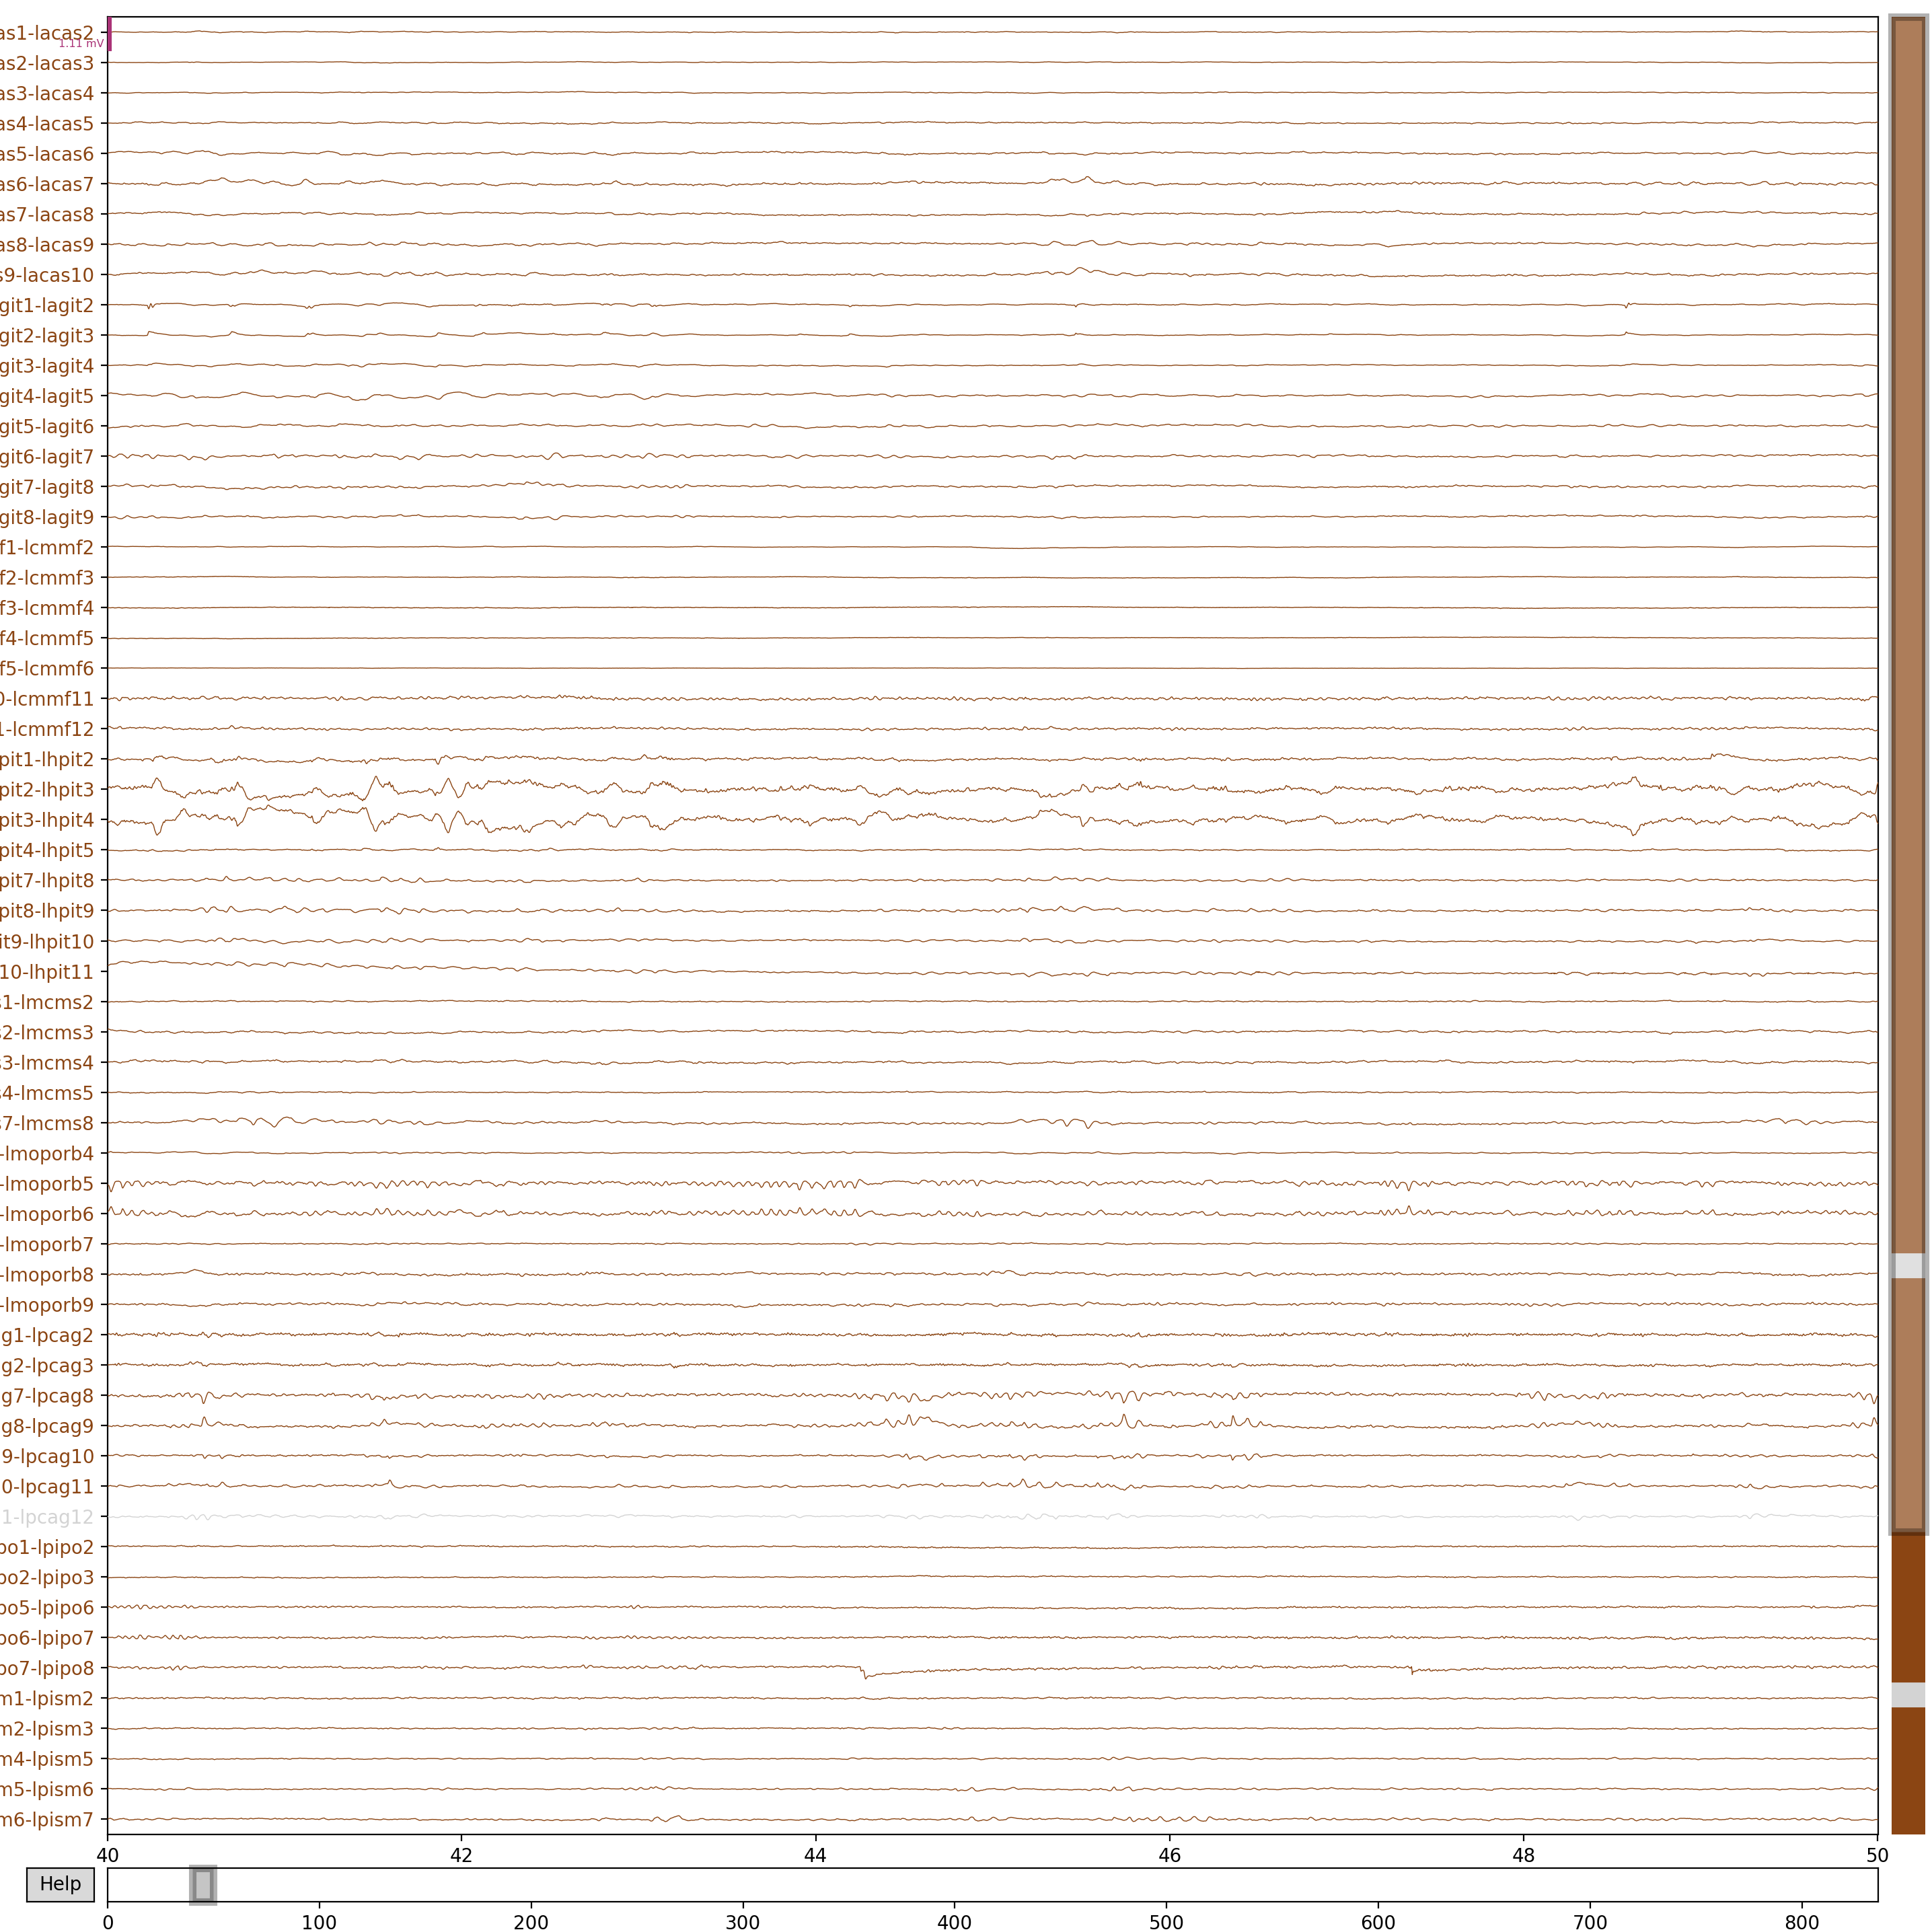

In [25]:
fig = mne_data_reref.plot(start=0, duration=10, n_channels=60, 
                      scalings=mne_data_reref._data.max()/20
                     )

Look at the power spectra for specific channels. Click the channels to see their names (e.g. if you need to pick out a bad ugly channel)

Effective window size : 4.096 (s)


<IPython.core.display.Javascript object>


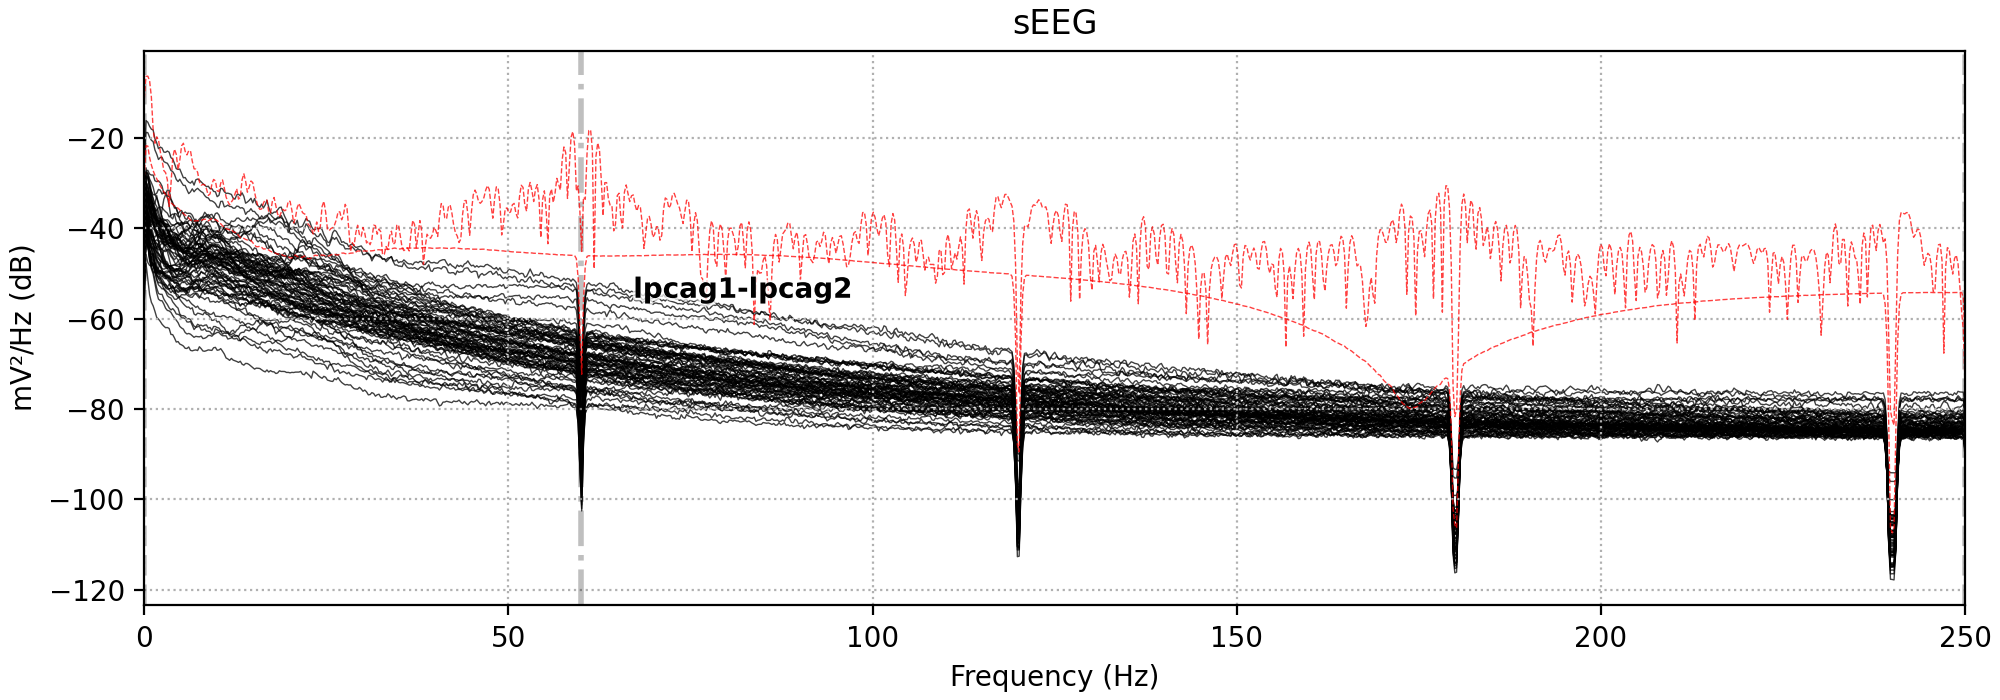

<IPython.core.display.Javascript object>


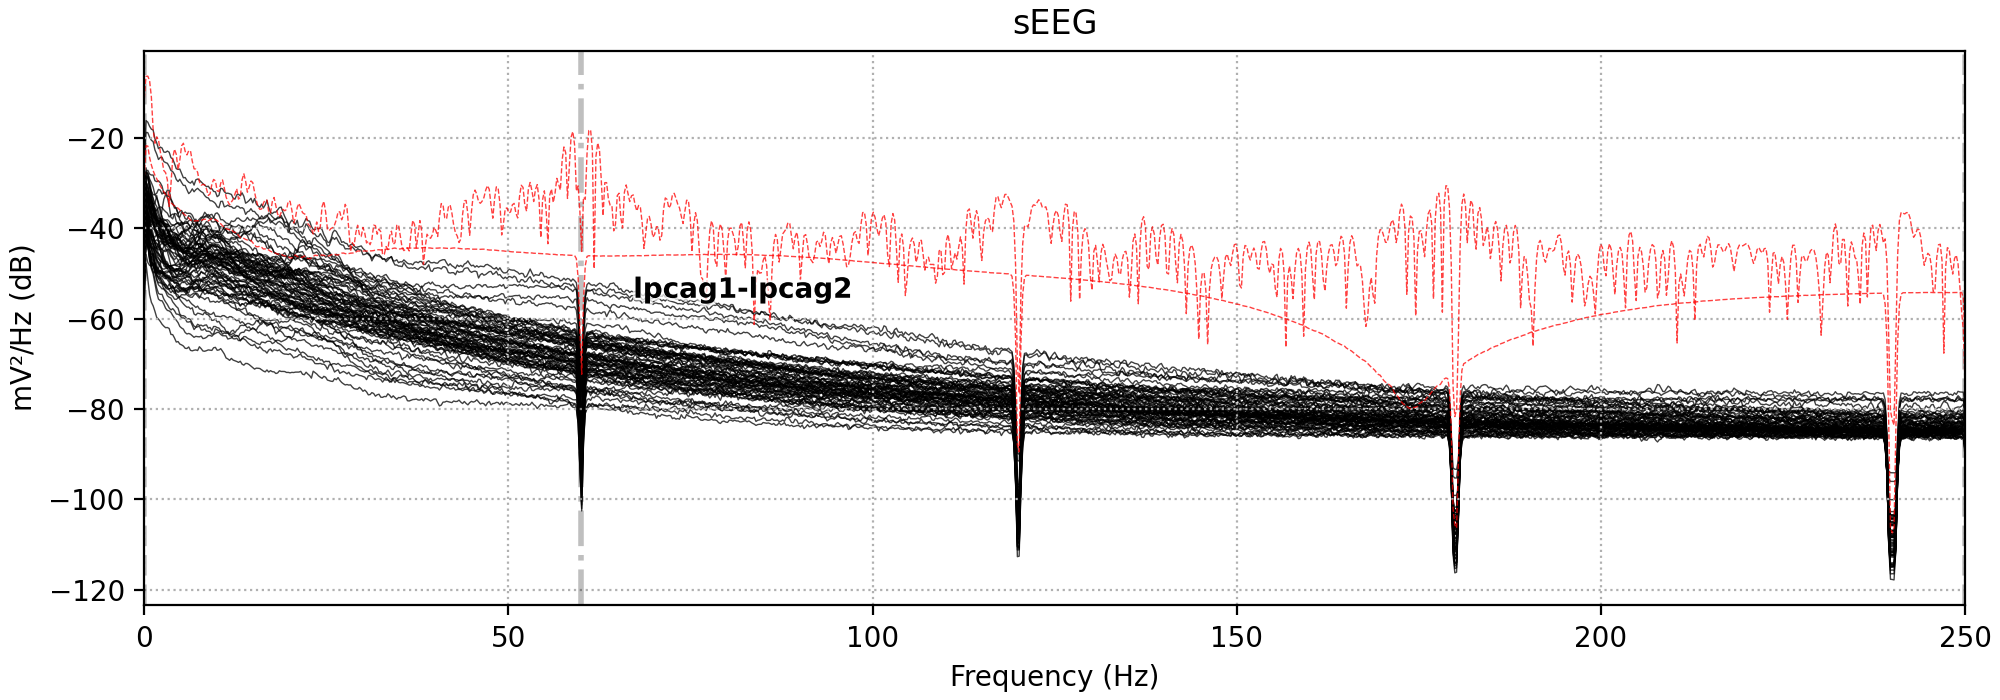

In [26]:
mne_data_reref.compute_psd().plot()

 - mne_data: a Raw mne object, where the data has been loaded, filtered for line noise, searched for bad channels, parsed for different data types, and resampled if necessary. 
 
 - mne_data_reref: an mne object containing re-referenced data (either white matter or bipolar)

If you have ran the preprocessing above, load the data instead: 

In [150]:
mne_data_reref.save(f'{save_path}/bp_ref_ieeg.fif', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day1/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day1/bp_ref_ieeg.fif
[done]


In [12]:
%matplotlib inline

## Load neural data

In [12]:
elec_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
mne_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
photodiode_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}

In [13]:
for ix, subj_id in enumerate(subj_ids): 
    for day in days:
        # Check if this day is in the dataset:
        if subj_df[day].values[ix] == 0:
            print (f'subject {subj_id} does not have Day 2 data')
            continue
        else:
            # Set paths
            load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
            save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'

            # Get electrode df 
            elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/{day}_reref_elec_df')

            mne_data_reref = mne.io.read_raw_fif(f'{save_path}/bp_ref_ieeg.fif', preload=True)

            photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)

            # Append to list 
            mne_dict[subj_id][day].append(mne_data_reref)

            photodiode_dict[subj_id][day].append(photodiode_data)

            elec_dict[subj_id][day].append(elec_df)

Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 394061 =      0.000 ...   788.122 secs
Ready.
Reading 0 ... 394061  =      0.000 ...   788.122 secs...
Opening raw data file /sc/arion/projects/guLab/Salman/EMU/MS012/neural/Day1/photodiode.fif...
Isotrak not found
    Range : 0 ... 807039 =      0.000 ...   788.124 secs
Ready.
Reading 0 ... 807039  =      0.000 ...   788.124 secs...
subject MS012 does not have Day 2 data


In [37]:
    IED_sec_dict = lfp_preprocess_utils.detect_IEDs(mne_data_reref, 
                                            peak_thresh=5, 
                                            closeness_thresh=0.25, 
                                            width_thresh=0.2)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  56 out of  60 | elapsed:   10.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.5s finished


In [50]:
mne_data_reref._data[0,:]

array([nan, nan, nan, ..., nan, nan, nan])

In [35]:

sig = mne_data_reref.get_data(picks=[ch_])[0, :]

In [36]:
sig.shape

(394062,)

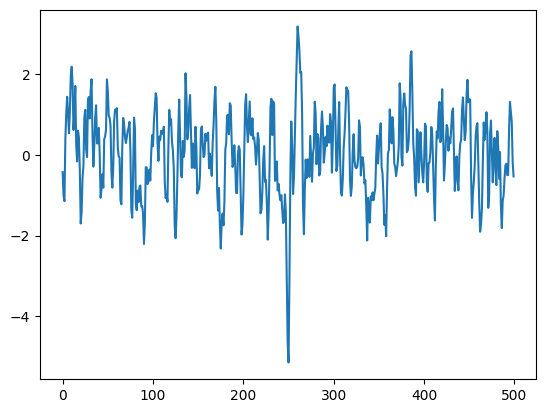

In [32]:
plt.plot(mne_data_reref._data[0, 93608-250:93608+250])


 - mne_dict: a dictionary containing all of your subjects' re-referenced mne data 
 
 - photodiode_dict: a dictionary containing all of your subjects' photodiode data 
 
 - elec_dict: a dictionary containing the paths to your subjects' electrode data 

## Sync behavioral and neural data



Here, we perform a critical step: computing the time offset between the computer that recorded the neural data and the laptop that featured the experiment. 

The function here only requires a **subset** of detected sync signals (i.e. photodiode deflections) to be detected to successfully compute this offset. 


First, some of the photodiode data can be a bit crummy, which you need to clean up in an idiosyncratic way... ugh

In [32]:
subj_id = 'MS015'
day = 'Day1'
temp_diode = photodiode_dict[subj_id][day][0]._data[0, :]
temp_diode[900000:] = np.nanmin(temp_diode)
# photodiode_dict[subj_id][day][0]._data = temp_diode[0:420000]
# temp_diode[temp_diode>.13] = 0.1
photodiode_dict[subj_id][day][0]._data = temp_diode


subj_id = 'MS022'
day = 'Day1'
temp_diode = np.abs(photodiode_dict[subj_id][day][0]._data[0,:])
temp_diode[temp_diode>.13] = 0.1
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS026'
day = 'Day1'
temp_diode = photodiode_dict[subj_id][day][0]._data[0,:]
temp_diode[temp_diode>4000] = 0
temp_diode[temp_diode<-4000] = 0
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS028'
day = 'Day1'
temp_diode = photodiode_dict[subj_id][day][0]._data[0,:]
temp_diode[temp_diode>4000] = 0
temp_diode[temp_diode<-3000] = 0
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS030'
day = 'Day1'
temp_diode = photodiode_dict[subj_id][day][0]._data[0,:]
temp_diode[temp_diode>0.005] = 0.005
temp_diode[temp_diode>-0.002] = 0.004
temp_diode[temp_diode<-0.004] = -0.004
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS034'
day = 'Day1'
temp_diode = -(photodiode_dict[subj_id][day][0]._data[0,:])
temp_diode[temp_diode>-0.225] = -0.225
temp_diode[temp_diode>-0.2375] = -0.225
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS035'
day = 'Day1'
temp_diode = -(photodiode_dict[subj_id][day][0]._data[0,:])
temp_diode[temp_diode>-0.25] = -0.25
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS035'
day = 'Day2'
temp_diode = -(photodiode_dict[subj_id][day][0]._data[0,:])
temp_diode[temp_diode>-0.25] = -0.25
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS036'
day = 'Day1'
temp_diode = -(photodiode_dict[subj_id][day][0]._data[0,:])
photodiode_dict[subj_id][day][0]._data = temp_diode


subj_id = 'MS036'
day = 'Day2'
temp_diode = -(photodiode_dict[subj_id][day][0]._data[0,:])
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS038'
day = 'Day1'
temp_diode = (photodiode_dict[subj_id][day][0]._data[0,:])
# temp_diode[temp_diode<0] = 0
# photodiode_dict[subj_id][day][0]._data = temp_diode

Now, let's compute the slopes and offsets

In [39]:
slopes = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
offsets = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}


for ix, subj_id in enumerate(subj_ids):
    for day in days:
        # Check if this day is in the dataset:
        if subj_df[day].values[ix] == 0:
            print (f'subject {subj_id} does not have Day 2 data')
            continue
        else:
            print(f'Working on subj {subj_id}')
            # Load the behavioral timestamps: 
            behav_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/behav/{day}'
            temp_df = pd.read_csv(glob(f'{behav_path}/*.csv')[0], index_col=None, header=0)
            # Load in the timestamps pertaining to your sync. If your task had a square pop up, for example, grab the times for that square's appearance from the behavioral logs.
            # Below, I do this for my own task's Psychopy output, but yours is probably coded differently. 
            beh_ts = temp_df[temp_df.keys()[temp_df.keys().str.startswith('sync') & temp_df.keys().str.endswith('started')]].values
            beh_ts = beh_ts[~np.isnan(beh_ts)] 

            # Synchronize to the photodiode or whatever your neural sync signal is
            height = 1
            windSize = 15
            smoothSize = 11
            
            # Can sometimes help to set some parameters manually for individuals with bad signal 
            if subj_id in ['MS015']:
                if day == 'Day1':
                    height = 1
                    windSize = 35
                    smoothSize = 10
                elif day == 'Day2':
                    height = 1.5
                    windSize = 20
                    smoothSize = 11                  
            if subj_id in ['MS020']:
                if day == 'Day1':
                    height = 1.5
#             if subj_id in ['MS030']:
#                 if day == 'Day1':
#                     height = 1.5
            if subj_id in ['MS038']:
                if day == 'Day1':
                    height = 1
                    windSize = 35
#             elif subj_id in ['MS022', 'MS025', 'MS026']:
#                 if day == 'Day1':
#                     height = 2
#             elif subj_id in ['MS028']:
#                 if day == 'Day1':
#                     height = 0.5            
            slope, offset = sync_utils.synchronize_data(beh_ts, 
                                                        photodiode_dict[subj_id][day][0], 
                                                        smoothSize=smoothSize, windSize=windSize, height=height)

#             print(slope)
#             print(offset)
            slopes[subj_id][day].append(slope)
            offsets[subj_id][day].append(offset)


Working on subj MS012
28 blocks
............................

found matches for 150 of 428 pulses
subject MS012 does not have Day 2 data
Working on subj MS015
10 blocks
..........

found matches for 105 of 380 pulses
Working on subj MS015
8 blocks
........

found matches for 160 of 164 pulses
Working on subj MS016
28 blocks
............................

found matches for 345 of 426 pulses
Working on subj MS016
9 blocks
.........

found matches for 75 of 139 pulses
Working on subj MS017
32 blocks
................................

found matches for 135 of 493 pulses
Working on subj MS017
Working on subj MS019
11 blocks
...........

found matches for 60 of 165 pulses
Working on subj MS019
10 blocks
..........

found matches for 135 of 164 pulses
Working on subj MS020
117 blocks
.....................................................................................................................

found matches for 120 of 1760 pulses
Working on subj MS020
10 blocks
..........

found matches 

In [297]:
%matplotlib inline

In [43]:
# Save the sync info
file = f'{base_dir}/projects/guLab/Salman/EMU/slopes.json'
with open(file, 'wb') as f: 
    pickle.dump(slopes, f, pickle.HIGHEST_PROTOCOL)
    f.close()
file = f'{base_dir}/projects/guLab/Salman/EMU/offsets.json'
with open(file, 'wb') as f: 
    pickle.dump(offsets, f, pickle.HIGHEST_PROTOCOL)
    f.close()


In [64]:
# slopes['MS038']['Day1'] = [] 
# offsets['MS038']['Day1'] = []


 - slopes: a dictionary containing the slopes (should be ~ 1) for each subject
 - offsets: a dictionary containing the offsets for each subject

Note: The slope should always be VERY close to 1! If you run into issues with syncing downstream, come back and check this... 

## Load the sync data

In [9]:
# Load the sync info
file = f'{base_dir}/projects/guLab/Salman/EMU/slopes.json'
with open(file, 'rb') as f: 
    slopes = pickle.load(f)
file = f'{base_dir}/projects/guLab/Salman/EMU/offsets.json'
with open(file, 'rb') as f: 
    offsets = pickle.load(f)


In [10]:
slopes

{'MS012': {'Day1': [0.9999892560991055], 'Day2': []},
 'MS015': {'Day1': [1.0007136066766493], 'Day2': [1.0000113058767246]},
 'MS016': {'Day1': [0.9999796222645818], 'Day2': [0.9999941256028682]},
 'MS017': {'Day1': [1.0006201052188766], 'Day2': [1.0020229387555606]},
 'MS019': {'Day1': [1.0000061316533204], 'Day2': [1.0000127069109512]},
 'MS020': {'Day1': [1.0000157003334416], 'Day2': [1.0000078981670395]},
 'MS022': {'Day1': [1.000003245457805], 'Day2': []},
 'MS023': {'Day1': [1.0000599483155062], 'Day2': [0.9999975710236938]},
 'MS024': {'Day1': [0.9999978254650277], 'Day2': [1.008323718673507]},
 'MS025': {'Day1': [1.0001245919264934], 'Day2': [1.000013653594013]},
 'MS026': {'Day1': [1.000008023619669], 'Day2': [0.9999917842323772]},
 'MS028': {'Day1': [0.999370696622421], 'Day2': []},
 'MS030': {'Day1': [0.9999782427874625], 'Day2': [1.0026312356140472]},
 'MS034': {'Day1': [1.005172825240541], 'Day2': []},
 'MS035': {'Day1': [0.9999793832257485], 'Day2': [0.9998973878167973]}

Note: I have two different tasks in one experiment

1) Decision-making 
2) Memory

Furthermore, the memory task is split into Day 1 and Day 2. So really, it's like having three tasks in one. So I will be performing the same steps repeatedly.

## Make epochs (decision-making task)

In [47]:
# Let's test out the new eopch code: 
subj_id = subj_ids[0]
day = 'Day1'
event = 'feedback_start'
buf = 1.0 # this is the buffer before and after that we use to limit edge effects for TFRs

IED_args = {'peak_thresh':5,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}
evs = {'gamble_start': [-1.0, 0.],
       'feedback_start': [0., 1.5],
       'baseline_start': [0., 0.75]}

load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}/bp_ref_ieeg.fif'

pre = evs[event][0]
post = evs[event][1]
fixed_baseline = None
behav_times = learn_df[(learn_df.participant==subj_id)][event]

# Load the data 
mne_data_reref = mne.io.read_raw_fif(save_path, preload=True)

IED_sec_dict = lfp_preprocess_utils.detect_IEDs(mne_data_reref, 
                                        peak_thresh=IED_args['peak_thresh'], 
                                        closeness_thresh=IED_args['closeness_thresh'], 
                                        width_thresh=IED_args['width_thresh'])

Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 394061 =      0.000 ...   788.122 secs
Ready.
Reading 0 ... 394061  =      0.000 ...   788.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  56 out of  60 | elapsed:   12.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.5s finished


In [51]:

slope = slopes[subj_id][day][0]
offset = offsets[subj_id][day][0]

In [54]:
ev_start_s = 0
ev_end_s = 1.5

In [61]:
# all behavioral times of interest 
beh_ts = [(float(x)*slope + offset) if x != 'None' else np.nan for x in behav_times]

# any NaN's (e.g. non-responses) should be removed. make sure to remove from the dataframes during later analysis too. 
beh_ts = [x for x in beh_ts if ~np.isnan(x)]

# Bin these times into the epoched bins
ev_starts = [x - ev_start_s for x in beh_ts]
ev_ends = [x + ev_end_s for x in beh_ts]

IED_df = lfp_preprocess_utils._bin_channelwise_times_into_behav_evs(IED_sec_dict, ev_starts, ev_ends)
artifact_df = lfp_preprocess_utils._bin_channelwise_times_into_behav_evs(artifact_sec_dict, ev_starts, ev_ends)


In [70]:
buf_s=1
behav_name = 'feedback_start'
baseline = None
downsamp_factor= None
detrend =0 

In [71]:
# Make behavioral events.
onset_beh = beh_ts
duration_beh = np.zeros_like(beh_ts).tolist()
descriptions_beh = [behav_name]*len(beh_ts)
ch_names_beh = []*len(beh_ts)

# Make mne annotations based on these descriptions
annot = mne.Annotations(onset=onset_beh,
                        duration=duration_beh,
                        description=descriptions_beh)

mne_data_reref.set_annotations(annot)
events_from_annot, event_dict = mne.events_from_annotations(mne_data_reref)

ev_epochs = mne.Epochs(mne_data_reref, 
    events_from_annot, 
    event_id=event_dict, 
    baseline=baseline, 
    tmin=ev_start_s - buf_s, 
    tmax=ev_end_s + buf_s, 
    detrend=detrend, 
    reject=None, 
    reject_by_annotation=False,
    preload=True)

# NOTE: I don't demean the data for DC offsets. This is mainly because any undetected large artifact would skew and screw us 
# before any of the following pre-processing steps, which would be hard to detect later.

# Filter and downsample the epochs 
if downsamp_factor is not None:
    ev_epochs.resample(sfreq=ev_epochs.info['sfreq']/downsamp_factor)

Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped


In [75]:
from neurodsp.spectral import compute_spectrum
from scipy.signal import hilbert, find_peaks, peak_widths, convolve


In [125]:
check_epoch_line_noise = True
if check_epoch_line_noise == True:
    notch_freqs = [120, 180, 240] 
    notch_ranges = np.concatenate([np.arange(x-3,x+4) for x in notch_freqs]).flatten().tolist()
    noisy_epochs_dict = {f'{x}':np.nan for x in ev_epochs.ch_names}

    for ch_ in ev_epochs.ch_names:
        sig = ev_epochs.get_data(picks=[ch_])[:,0,:]
        noise_evs = []
        # compute the power spectrum
        freqs, psds = compute_spectrum(sig, ev_epochs.info['sfreq'], method='welch', avg_type='median')

        for event in np.arange(sig.shape[0]):
            # Find peaks in the power spectrum
            peaks, _ = find_peaks(np.log10(psds[event, :]), prominence=3.)  # Adjust threshold as needed
            peak_freqs = freqs[peaks]
            # do they intersect with noise ranges?
            intersection = set(peak_freqs) & set(notch_ranges)
            if intersection:
                noise_evs.append(event)
        noisy_epochs_dict[ch_] = noise_evs

rmtpt8-rmtpt9
1


In [98]:
    notch_freqs = [60, 120, 180] 
    notch_ranges = np.concatenate([np.arange(x-3,x+4) for x in notch_freqs]).flatten().tolist()

In [99]:
notch_ranges

[57,
 58,
 59,
 60,
 61,
 62,
 63,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 177,
 178,
 179,
 180,
 181,
 182,
 183]

In [ ]:
notch_ranges = np.concatenate([np.arange(x-3,x+4) for x in notch_freqs]).flatten().tolist()

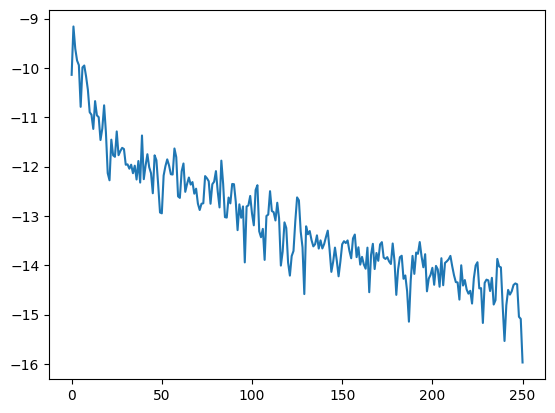

In [102]:
plt.plot(freqs, np.log10(psds[77, :]))

In [104]:
np.argmax(np.var(psds[:, notch_ranges], axis=1))

77

In [101]:
freqs

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [79]:
noisy_epochs_dict

{'racas1-racas2': [7,
  9,
  12,
  14,
  17,
  21,
  25,
  26,
  32,
  35,
  37,
  40,
  42,
  58,
  62,
  70,
  71,
  75,
  77,
  78],
 'racas2-racas3': [1,
  6,
  7,
  8,
  12,
  17,
  19,
  24,
  27,
  35,
  41,
  42,
  44,
  46,
  50,
  51,
  57,
  60,
  61,
  62,
  67,
  68,
  69,
  70,
  75,
  78,
  79],
 'racas3-racas4': [7,
  9,
  12,
  25,
  35,
  36,
  37,
  46,
  48,
  50,
  53,
  55,
  57,
  63,
  65,
  69,
  73,
  74,
  75,
  76],
 'racas4-racas5': [6,
  8,
  10,
  12,
  15,
  20,
  22,
  27,
  31,
  33,
  34,
  41,
  47,
  51,
  53,
  54,
  60,
  65,
  66,
  72,
  74,
  78],
 'racas5-racas6': [2, 3, 25, 28, 30, 40, 46, 50, 52, 54, 56, 57, 62, 69],
 'racas6-racas7': [1,
  3,
  4,
  5,
  16,
  25,
  28,
  29,
  34,
  35,
  43,
  49,
  52,
  56,
  59,
  69,
  73,
  76,
  77],
 'racas8-racas9': [4, 11, 24, 25, 32, 39, 40, 49, 50, 53, 59, 62, 63, 74, 79],
 'racas9-racas10': [8,
  9,
  14,
  20,
  22,
  26,
  32,
  37,
  40,
  42,
  44,
  48,
  53,
  56,
  73,
  75,
  76,
  78]

In [44]:
artifact_sec_dict['raglt1-raglt2'] * 500

array([ 10387.,  12121.,  16105.,  17504.,  24500.,  30556.,  34386.,
        34432.,  43913.,  45077.,  48825.,  56037.,  66723.,  67165.,
        72882.,  72883.,  72884.,  72885.,  73300.,  73301.,  75635.,
        75649.,  75650.,  81251.,  82874.,  83045.,  83046.,  83047.,
        83175.,  83179.,  83180.,  84215.,  85443.,  85444.,  85445.,
        98779., 107669., 110336., 110895., 114782., 115741., 115742.,
       116301., 116302., 116303., 116311., 116312., 116313., 117394.,
       117395., 119117., 119465., 133050., 139193., 139194., 144638.,
       151585., 151586., 154390., 154391., 154392., 154393., 164253.,
       166526., 166541., 166542., 166543., 167864., 167865., 168019.,
       169254., 169255., 197577., 198626., 199036., 202426., 202910.,
       205627., 205645., 206588., 206589., 211745., 213628., 213629.,
       213630., 214263., 214686., 216420., 220131., 221799., 222060.,
       223583., 225229., 227395., 227396., 227397., 229325., 229326.,
       232012., 2320

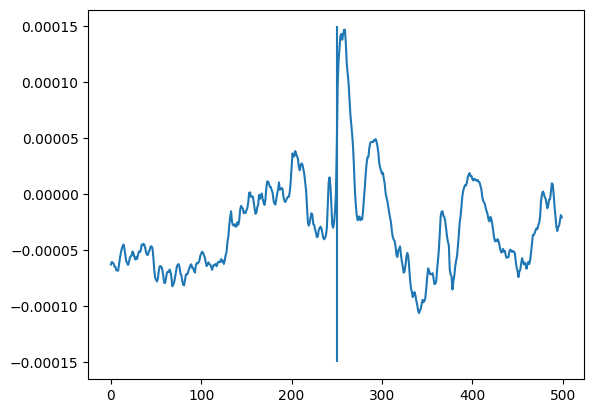

In [43]:
plt.plot(mne_data_reref.get_data(picks=['raglt1-raglt2'])[0, 45077-250:45077+250])
plt.vlines([250], -0.00015, 0.00015)

In [ ]:
# THAT'S ALOT OF ARTIFACTS IN DEEP BRAIN ELECTRODES 

Make epochs and remove IEDs. Currently just doing this for one example period - when subjects receive feedback.

In [11]:
# set some windows of interest 

buf = 1.0 # this is the buffer before and after that we use to limit edge effects for TFRs

IED_args = {'peak_thresh':5,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

# evs = ['gamble_start', 'feedback_start', 'baseline_start']
evs = {'gamble_start': [-1.0, 0.],
       'feedback_start': [0., 1.5],
       'baseline_start': [0., 0.75]}

# evs = {'feedback_start': [-0.5, 1.5]}


# add behavioral times of interest 
for subj_id in subj_ids:
    for day in ['Day1']:
        # Set paths
        load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
        save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'

        epochs_all_evs = {f'{x}': np.nan for x in evs}
        for event in evs.keys():
            pre = evs[event][0]
            post = evs[event][1]
            fixed_baseline = None
            behav_times = learn_df[(learn_df.participant==subj_id)][event]

            epochs = lfp_preprocess_utils.make_epochs(load_path=f'{save_path}/bp_ref_ieeg.fif', 
                                                      slope=slopes[subj_id][day][0], offset=offsets[subj_id][day][0], 
                                                      behav_name=event, behav_times=behav_times,
                                                      ev_start_s=pre, ev_end_s=post, buf_s=1, downsamp_factor=None, IED_args=IED_args, detrend=0)

            
            epochs_all_evs[event] = epochs
#             epochs_all_evs[event].save(f'{save_path}/{event}-epo.fif', overwrite=True)

        



Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 394061 =      0.000 ...   788.122 secs
Ready.
Reading 0 ... 394061  =      0.000 ...   788.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  56 out of  60 | elapsed:    3.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.6s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 394061 =      0.000 ...   788.122 secs
Ready.
Reading 0 ... 394061  =      0.000 ...   788.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.5s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 394061 =      0.000 ...   788.122 secs
Ready.
Reading 0 ... 394061  =      0.000 ...   788.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.5s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI001/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 468351 =      0.000 ...   936.702 secs
Ready.
Reading 0 ... 468351  =      0.000 ...   936.702 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.5s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI001/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 468351 =      0.000 ...   936.702 secs
Ready.
Reading 0 ... 468351  =      0.000 ...   936.702 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.5s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI001/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 468351 =      0.000 ...   936.702 secs
Ready.
Reading 0 ... 468351  =      0.000 ...   936.702 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.5s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 737811 =      0.000 ...  1475.622 secs
Ready.
Reading 0 ... 737811  =      0.000 ...  1475.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    1.3s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 737811 =      0.000 ...  1475.622 secs
Ready.
Reading 0 ... 737811  =      0.000 ...  1475.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    1.3s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 737811 =      0.000 ...  1475.622 secs
Ready.
Reading 0 ... 737811  =      0.000 ...  1475.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    1.3s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 407811 =      0.000 ...   815.622 secs
Ready.
Reading 0 ... 407811  =      0.000 ...   815.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.5s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 407811 =      0.000 ...   815.622 secs
Ready.
Reading 0 ... 407811  =      0.000 ...   815.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.5s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 407811 =      0.000 ...   815.622 secs
Ready.
Reading 0 ... 407811  =      0.000 ...   815.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.5s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI002/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 977663 =      0.000 ...  1955.326 secs
Ready.
Reading 0 ... 977663  =      0.000 ...  1955.326 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 111 out of 115 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 111 out of 115 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    3.3s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI002/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 977663 =      0.000 ...  1955.326 secs
Ready.
Reading 0 ... 977663  =      0.000 ...  1955.326 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 111 out of 115 | elapsed:    3.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 111 out of 115 | elapsed:    3.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    3.1s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI002/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 977663 =      0.000 ...  1955.326 secs
Ready.
Reading 0 ... 977663  =      0.000 ...  1955.326 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 111 out of 115 | elapsed:    3.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 111 out of 115 | elapsed:    3.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    3.9s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 883624 =      0.000 ...  1767.248 secs
Ready.
Reading 0 ... 883624  =      0.000 ...  1767.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    1.4s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 883624 =      0.000 ...  1767.248 secs
Ready.
Reading 0 ... 883624  =      0.000 ...  1767.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    1.4s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 883624 =      0.000 ...  1767.248 secs
Ready.
Reading 0 ... 883624  =      0.000 ...  1767.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    1.4s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 592311 =      0.000 ...  1184.622 secs
Ready.
Reading 0 ... 592311  =      0.000 ...  1184.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.9s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 592311 =      0.000 ...  1184.622 secs
Ready.
Reading 0 ... 592311  =      0.000 ...  1184.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.8s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 592311 =      0.000 ...  1184.622 secs
Ready.
Reading 0 ... 592311  =      0.000 ...  1184.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.8s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS022/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 1214374 =      0.000 ...  2428.748 secs
Ready.
Reading 0 ... 1214374  =      0.000 ...  2428.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    1.4s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS022/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 1214374 =      0.000 ...  2428.748 secs
Ready.
Reading 0 ... 1214374  =      0.000 ...  2428.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    1.2s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS022/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 1214374 =      0.000 ...  2428.748 secs
Ready.
Reading 0 ... 1214374  =      0.000 ...  2428.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwid

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    1.2s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS023/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 896499 =      0.000 ...  1792.998 secs
Ready.
Reading 0 ... 896499  =      0.000 ...  1792.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  97 out of 101 | elapsed:    2.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    2.2s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS023/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 896499 =      0.000 ...  1792.998 secs
Ready.
Reading 0 ... 896499  =      0.000 ...  1792.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    2.3s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS023/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 896499 =      0.000 ...  1792.998 secs
Ready.
Reading 0 ... 896499  =      0.000 ...  1792.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  97 out of 101 | elapsed:    1.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    2.2s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI003/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 577023 =      0.000 ...  1154.046 secs
Ready.
Reading 0 ... 577023  =      0.000 ...  1154.046 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  71 out of  75 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI003/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 577023 =      0.000 ...  1154.046 secs
Ready.
Reading 0 ... 577023  =      0.000 ...  1154.046 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  71 out of  75 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.0s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI003/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 577023 =      0.000 ...  1154.046 secs
Ready.
Reading 0 ... 577023  =      0.000 ...  1154.046 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  71 out of  75 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 534187 =      0.000 ...  1068.374 secs
Ready.
Reading 0 ... 534187  =      0.000 ...  1068.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  92 out of  96 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    1.1s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 534187 =      0.000 ...  1068.374 secs
Ready.
Reading 0 ... 534187  =      0.000 ...  1068.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  92 out of  96 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    1.1s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 534187 =      0.000 ...  1068.374 secs
Ready.
Reading 0 ... 534187  =      0.000 ...  1068.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  92 out of  96 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    1.1s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 842415 =      0.000 ...  1684.830 secs
Ready.
Reading 0 ... 842415  =      0.000 ...  1684.830 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  71 out of  75 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  71 out of  75 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.6s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 842415 =      0.000 ...  1684.830 secs
Ready.
Reading 0 ... 842415  =      0.000 ...  1684.830 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  71 out of  75 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  71 out of  75 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.6s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 842415 =      0.000 ...  1684.830 secs
Ready.
Reading 0 ... 842415  =      0.000 ...  1684.830 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  71 out of  75 | elapsed:    1.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  71 out of  75 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.6s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS028/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 609175 =      0.000 ...  1218.350 secs
Ready.
Reading 0 ... 609175  =      0.000 ...  1218.350 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    1.3s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS028/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 609175 =      0.000 ...  1218.350 secs
Ready.
Reading 0 ... 609175  =      0.000 ...  1218.350 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    1.2s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS028/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 609175 =      0.000 ...  1218.350 secs
Ready.
Reading 0 ... 609175  =      0.000 ...  1218.350 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    1.2s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS030/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 417968 =      0.000 ...   835.936 secs
Ready.
Reading 0 ... 417968  =      0.000 ...   835.936 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.6s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS030/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 417968 =      0.000 ...   835.936 secs
Ready.
Reading 0 ... 417968  =      0.000 ...   835.936 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.6s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS030/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 417968 =      0.000 ...   835.936 secs
Ready.
Reading 0 ... 417968  =      0.000 ...   835.936 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.6s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI004/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 614271 =      0.000 ...  1228.542 secs
Ready.
Reading 0 ... 614271  =      0.000 ...  1228.542 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:    1.6s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI004/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 614271 =      0.000 ...  1228.542 secs
Ready.
Reading 0 ... 614271  =      0.000 ...  1228.542 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:    1.5s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI004/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 614271 =      0.000 ...  1228.542 secs
Ready.
Reading 0 ... 614271  =      0.000 ...  1228.542 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:    1.6s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 611843 =      0.000 ...  1223.686 secs
Ready.
Reading 0 ... 611843  =      0.000 ...  1223.686 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.5s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 611843 =      0.000 ...  1223.686 secs
Ready.
Reading 0 ... 611843  =      0.000 ...  1223.686 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.5s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 611843 =      0.000 ...  1223.686 secs
Ready.
Reading 0 ... 611843  =      0.000 ...  1223.686 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.5s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 446780 =      0.000 ...   893.560 secs
Ready.
Reading 0 ... 446780  =      0.000 ...   893.560 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    0.8s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 446780 =      0.000 ...   893.560 secs
Ready.
Reading 0 ... 446780  =      0.000 ...   893.560 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    0.8s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 446780 =      0.000 ...   893.560 secs
Ready.
Reading 0 ... 446780  =      0.000 ...   893.560 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    0.8s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI006/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 469631 =      0.000 ...   939.262 secs
Ready.
Reading 0 ... 469631  =      0.000 ...   939.262 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:    1.2s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI006/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 469631 =      0.000 ...   939.262 secs
Ready.
Reading 0 ... 469631  =      0.000 ...   939.262 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:    1.1s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI006/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 469631 =      0.000 ...   939.262 secs
Ready.
Reading 0 ... 469631  =      0.000 ...   939.262 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:    1.1s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI007/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 408703 =      0.000 ...   817.406 secs
Ready.
Reading 0 ... 408703  =      0.000 ...   817.406 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    0.8s finished


Used Annotations descriptions: ['gamble_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI007/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 408703 =      0.000 ...   817.406 secs
Ready.
Reading 0 ... 408703  =      0.000 ...   817.406 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 H

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    0.8s finished


Used Annotations descriptions: ['feedback_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI007/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 408703 =      0.000 ...   817.406 secs
Ready.
Reading 0 ... 408703  =      0.000 ...   817.406 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    0.8s finished


Used Annotations descriptions: ['baseline_start']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped


In [169]:
# load_path=f'{save_path}/bp_ref_ieeg.fif'
# slope=slopes[subj_id][day][0]
# offset=offsets[subj_id][day][0]
# behav_name=event
# behav_times=behav_times
# ev_start_s=pre
# ev_end_s=post
# buf_s=1
# downsamp_factor=None
# IED_args=IED_args
# detrend=0

In [170]:
# # Load the data 
# mne_data_reref = mne.io.read_raw_fif(load_path, preload=True)

# IED_sec_dict = lfp_preprocess_utils.detect_IEDs(mne_data_reref, 
#                                         peak_thresh=IED_args['peak_thresh'], 
#                                         closeness_thresh=IED_args['closeness_thresh'], 
#                                         width_thresh=IED_args['width_thresh'])

# # all behavioral times of interest 
# beh_ts = [(float(x)*slope + offset) if x != 'None' else np.nan for x in behav_times]

# # any NaN's (e.g. non-responses) should be removed. make sur to remove from the dataframes during later analysis too. 
# beh_ts = [x for x in beh_ts if ~np.isnan(x)]

# # Make behavioral events.
# onset_beh = beh_ts
# duration_beh = np.zeros_like(beh_ts).tolist()
# descriptions_beh = [behav_name]*len(beh_ts)
# ch_names_beh = []*len(beh_ts)

# # Make mne annotations based on these descriptions
# annot = mne.Annotations(onset=onset_beh,
#                         duration=duration_beh,
#                         description=descriptions_beh)

# mne_data_reref.set_annotations(annot)
# events_from_annot, event_dict = mne.events_from_annotations(mne_data_reref)

In [171]:
#     ev_epochs = mne.Epochs(mne_data_reref, 
#         events_from_annot, 
#         event_id=event_dict, 
#         baseline=None, 
#         tmin=ev_start_s - buf_s, 
#         tmax=ev_end_s + buf_s, 
#         detrend=detrend, 
#         reject=None, 
#         reject_by_annotation=False,
#         preload=True)

If you want to extract a dictionary of good and bad epochs by channel, use the following: 

In [ ]:
good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)


In [254]:
# annot_df = ev_epochs._annotations.to_data_frame()

In [255]:
# bad_df = annot_df[annot_df.description.str.startswith('bad')].reset_index()

In [256]:
# bad_df.ch_names = bad_df.ch_names.apply(lambda x: x[0])

In [258]:
# bad_df['event'] = np.nan
# bad_times_s = _annotations_starts_stops(mne_data_reref, ['BAD'])[0] / mne_data_reref.info['sfreq']

## Make epochs (memory)

In [12]:
# set some windows of interest 

buf = 1.0 # this is the buffer before and after that we use to limit edge effects for TFRs

IED_args = {'peak_thresh':5,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

evs = {'recog_time': [-1.0, 0.0],
       'baseline_start_mem': [0, 0.75]}


# add behavioral times of interest 
for ix, subj_id in enumerate(subj_ids):
    for day in ['Day1']: 
        if (day=='Day2') & (subj_days[ix]==0):
            continue
        else:
            # Set paths
            load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
            save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'

            epochs_all_evs = {f'{x}': np.nan for x in evs}
            for event in evs.keys():
                pre = evs[event][0]
                post = evs[event][1]
                fixed_baseline = None
                behav_times = combined_df[(combined_df.participant==subj_id) & (combined_df.condition==day)][event]

    #             baseline_times = combined_df[(combined_df.participant==subj_id) & (combined_df.condition==f'{day}')].dropna(subset='trials_gamble').baseline_start_mem

                epochs = lfp_preprocess_utils.make_epochs(load_path=f'{save_path}/bp_ref_ieeg.fif', 
                                                          slope=slopes[subj_id][day][0], offset=offsets[subj_id][day][0], 
                                                          behav_name=event, behav_times=behav_times,
                                                          ev_start_s=pre, ev_end_s=post, buf_s=1, downsamp_factor=None, IED_args=IED_args, detrend=0)


                epochs_all_evs[event] = epochs
                epochs_all_evs[event].save(f'{save_path}/{event}-epo.fif', overwrite=True)





Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 394061 =      0.000 ...   788.122 secs
Ready.
Reading 0 ... 394061  =      0.000 ...   788.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.5s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 394061 =      0.000 ...   788.122 secs
Ready.
Reading 0 ... 394061  =      0.000 ...   788.122 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.5s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI001/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 468351 =      0.000 ...   936.702 secs
Ready.
Reading 0 ... 468351  =      0.000 ...   936.702 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.5s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI001/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 468351 =      0.000 ...   936.702 secs
Ready.
Reading 0 ... 468351  =      0.000 ...   936.702 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    0.5s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 737811 =      0.000 ...  1475.622 secs
Ready.
Reading 0 ... 737811  =      0.000 ...  1475.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    1.2s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 737811 =      0.000 ...  1475.622 secs
Ready.
Reading 0 ... 737811  =      0.000 ...  1475.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    1.3s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 407811 =      0.000 ...   815.622 secs
Ready.
Reading 0 ... 407811  =      0.000 ...   815.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.6s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 407811 =      0.000 ...   815.622 secs
Ready.
Reading 0 ... 407811  =      0.000 ...   815.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.6s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI002/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 977663 =      0.000 ...  1955.326 secs
Ready.
Reading 0 ... 977663  =      0.000 ...  1955.326 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 111 out of 115 | elapsed:    3.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 111 out of 115 | elapsed:    6.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    6.8s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI002/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 977663 =      0.000 ...  1955.326 secs
Ready.
Reading 0 ... 977663  =      0.000 ...  1955.326 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 111 out of 115 | elapsed:    3.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 111 out of 115 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:    2.5s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 883624 =      0.000 ...  1767.248 secs
Ready.
Reading 0 ... 883624  =      0.000 ...  1767.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    1.5s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 883624 =      0.000 ...  1767.248 secs
Ready.
Reading 0 ... 883624  =      0.000 ...  1767.248 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    1.4s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 592311 =      0.000 ...  1184.622 secs
Ready.
Reading 0 ... 592311  =      0.000 ...  1184.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.9s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 592311 =      0.000 ...  1184.622 secs
Ready.
Reading 0 ... 592311  =      0.000 ...  1184.622 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.8s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS022/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 1214374 =      0.000 ...  2428.748 secs
Ready.
Reading 0 ... 1214374  =      0.000 ...  2428.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    1.2s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS022/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 1214374 =      0.000 ...  2428.748 secs
Ready.
Reading 0 ... 1214374  =      0.000 ...  2428.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lowe

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    1.2s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS023/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 896499 =      0.000 ...  1792.998 secs
Ready.
Reading 0 ... 896499  =      0.000 ...  1792.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    2.0s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS023/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 896499 =      0.000 ...  1792.998 secs
Ready.
Reading 0 ... 896499  =      0.000 ...  1792.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:    2.0s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI003/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 577023 =      0.000 ...  1154.046 secs
Ready.
Reading 0 ... 577023  =      0.000 ...  1154.046 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.1s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI003/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 577023 =      0.000 ...  1154.046 secs
Ready.
Reading 0 ... 577023  =      0.000 ...  1154.046 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.1s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 534187 =      0.000 ...  1068.374 secs
Ready.
Reading 0 ... 534187  =      0.000 ...  1068.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    1.3s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 534187 =      0.000 ...  1068.374 secs
Ready.
Reading 0 ... 534187  =      0.000 ...  1068.374 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  92 out of  96 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    1.9s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 842415 =      0.000 ...  1684.830 secs
Ready.
Reading 0 ... 842415  =      0.000 ...  1684.830 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  71 out of  75 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  71 out of  75 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.9s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 842415 =      0.000 ...  1684.830 secs
Ready.
Reading 0 ... 842415  =      0.000 ...  1684.830 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  71 out of  75 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  71 out of  75 | elapsed:    2.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    2.6s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS028/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 609175 =      0.000 ...  1218.350 secs
Ready.
Reading 0 ... 609175  =      0.000 ...  1218.350 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    2.3s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS028/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 609175 =      0.000 ...  1218.350 secs
Ready.
Reading 0 ... 609175  =      0.000 ...  1218.350 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:    2.3s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS030/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 417968 =      0.000 ...   835.936 secs
Ready.
Reading 0 ... 417968  =      0.000 ...   835.936 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.2s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS030/neural/Day1/bp_ref_ieeg.fif...
    Reading extended channel information
    Range : 0 ... 417968 =      0.000 ...   835.936 secs
Ready.
Reading 0 ... 417968  =      0.000 ...   835.936 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    1.1s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
    Writing channel names to FIF truncated to 15 characters with remapping
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI004/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 614271 =      0.000 ...  1228.542 secs
Ready.
Reading 0 ... 614271  =      0.000 ...  1228.542 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 107 out of 111 | elapsed:    2.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:    2.6s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI004/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 614271 =      0.000 ...  1228.542 secs
Ready.
Reading 0 ... 614271  =      0.000 ...  1228.542 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 111 out of 111 | elapsed:    2.5s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 611843 =      0.000 ...  1223.686 secs
Ready.
Reading 0 ... 611843  =      0.000 ...  1223.686 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 104 out of 108 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.5s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 611843 =      0.000 ...  1223.686 secs
Ready.
Reading 0 ... 611843  =      0.000 ...  1223.686 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.5s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 446780 =      0.000 ...   893.560 secs
Ready.
Reading 0 ... 446780  =      0.000 ...   893.560 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    1.1s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 446780 =      0.000 ...   893.560 secs
Ready.
Reading 0 ... 446780  =      0.000 ...   893.560 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  77 out of  81 | elapsed:    1.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    1.3s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI006/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 469631 =      0.000 ...   939.262 secs
Ready.
Reading 0 ... 469631  =      0.000 ...   939.262 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:    1.3s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI006/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 469631 =      0.000 ...   939.262 secs
Ready.
Reading 0 ... 469631  =      0.000 ...   939.262 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:    1.2s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI007/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 408703 =      0.000 ...   817.406 secs
Ready.
Reading 0 ... 408703  =      0.000 ...   817.406 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper tra

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    1.5s finished


Used Annotations descriptions: ['recog_time']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/guLab/Salman/EphysAnalyses/UI007/neural/Day1/bp_ref_ieeg.fif...
    Range : 0 ... 408703 =      0.000 ...   817.406 secs
Ready.
Reading 0 ... 408703  =      0.000 ...   817.406 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    0.9s finished


Used Annotations descriptions: ['baseline_start_mem']
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1376 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.


## Extract the relevant dataframes and plots for one subject before expanding to group analysis: 

We probably want to produce two dataframes: 

1. Electrode-level: This is the highest-level dataframe, which is computing electrode-level traits for all trials, which cannot be computed at the trial-level, as well as parsing by conditions. Should be mergeable with the next level.

2. Trial-level: This is the second-level dataframe, which is computing trial-level traits for each electrode. 

3. Timewise: This is the third-level dataframe, used sparingly. It will include timepoints for time-specific results. 

This involves running a series of analyses: 


0. Compute power spectrum 

1. FOOOF (all trials) 

2. FOOOF (conditions) 

3. TFR 

4. eBOSC 

5. catch-22 traits (ML)

6. ripple algorithm (TBD)

7. temporally-resolved regression (optional - timewise)

8. connectivity 

9. pac 


Each analysis also has the potential to generate both data objects as well as plots that we might want to sve. We should make it optional as to whether all these exhaust fumes should actually be saved or not. 

## Time-series characteristics (Catch-22) 

Here, we aim to characterize some linear AND non-linear explanatory features of our timeseries. I don't use this much yet but useful for ML approaches. 

In [330]:
# import warnings
# warnings.filterwarnings('ignore')

In [504]:
# ev_dict = {'feedback_start': [-0.5, 1.5]}

# #        'baseline_start': [0, 0.75]
# # 'gamble_start': [-1.0, 0.5],

# # Define peak_width, peak_height, peak_threshold, max_n_peaks
# FOOOF_kwargs = {'peak_width_limits': [1, 8], 
#                'min_peak_height': 0.1,
#                 'peak_threshold': 1.,
#                 'max_n_peaks': 3,
#                'freq_range': [1, 30]}
 
# # Define our frequency bands of interest
# band_dict = {'delta' : [1, 4],
#                'theta' : [4, 8],
#                'alpha' : [8, 13],
#                'beta' : [13, 30]}

# conditions = ['rpe>0',
#              'rpe<1']


# # For now, let's go channel-by-channel, otherwise I would define our ROIs as such:
# rois = ['hippocampus', 'amygdala', 'insula', 'parahippocampal', 'entorhinal', 'anterior_cingulate']

# all_dfs = []

# for ix, subj_id in enumerate(subj_ids):
#     # Load one person's data 
#     for day in ['Day1']:
#         load_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
#         for event in ev_dict.keys():   
#             # filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/FOOOF/{event}'
#             # if not os.path.exists(f'{filepath}/plots'):
#             #     os.makedirs(f'{filepath}/plots')
#             # if not os.path.exists(f'{filepath}/dfs'):
#             #     os.makedirs(f'{filepath}/dfs')

#             mne_data_reref = mne.read_epochs(f'{load_path}/{event}-epo.fif', preload=True)
#             # Put in the behavioral data for the different tasks
#             evs_for_dm_only = behav_data[(behav_data.participant==subj_id)]
#             evs_for_dm_and_mem = combined_df[(combined_df.participant==subj_id)]
#             mne_data_reref.metadata = evs_for_dm_only
            
#             if evs_for_dm_and_mem.shape[0]<160: 
#                 print('not enough recalls') 
#                 continue

#             save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}'
#             # Get electrode df 
#             elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
#             # electrode files could either be csv or excel
#             elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
#             # There should really only be one 
#             elec_file = elec_files[0]

#         #     # IF Picking ROI: Revise labelling in electrode csv in order to match the re-referenced channel names 
#             elec_data = lfp_preprocess_utils.load_elec(elec_file)
#             anode_list = [x.split('-')[0] for x in mne_data_reref.ch_names]
#             elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
#             elec_df['label'] =  elec_df.label.apply(lambda x: [a for a in mne_data_reref.ch_names if str(x).lower() in a.split('-')[0]][0])

#             all_aucs = []
#             all_chans = [] 
#             all_regions = [] 

#             progress_bar = tqdm(mne_data_reref.ch_names, ascii=True, desc='Computing catch-22 classifier')

#             for chan in progress_bar: 

#                 dfs = []

#                 # Can pick the epoch depending on the event being selected
#                 chan_epochs = mne_data_reref.copy().pick_channels([chan])

#                 region = analysis_utils.select_rois_picks(elec_df, chan)

#                 df_all = [] 
#                 for ix, signal in enumerate(chan_epochs._data.squeeze()):
#                     catch_22_df = analysis_utils.hctsa_signal_features(signal).astype(float)
#                     df_all.append(catch_22_df)

#                 catch_22_names = list(catch_22_df.keys().values.astype('str'))

#                 df_all = pd.concat(df_all)
#                 df_all['recognition'] = evs_for_dm_only.merge(evs_for_dm_and_mem,on='img_path').hits.astype(int).tolist()
#                 df_all['chan'] = chan
#                 df_all['subj'] = subj_id 
#                 df_all['region'] = region
#                 all_dfs.append(df_all)
# #                 # zdf = df_all.apply(zscore)

# #                 X = df_all[catch_22_names].values
# #                 y = evs_for_dm_only.merge(evs_for_dm_and_mem,on='img_path').hits.astype(int).tolist()



# #                 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# #                 from sklearn import preprocessing
# #                 scaler = preprocessing.StandardScaler().fit(X_train)
# #                 X_scaled = scaler.transform(X_train)

# #                 # Create a logistic regression model
# #                 model = LogisticRegression()

# #                 # Train the model using the training data
# #                 model.fit(X_scaled, y_train)

# #                 predictions = model.predict(X_test)


# #                 # Calculate AUC-ROC score
# #                 auc_roc = roc_auc_score(y_test, predictions)

# #                 # print("AUC-ROC Score:", auc_roc)

# #                 all_aucs.append(auc_roc)
#                 # all_chans.append(chan)
#                 # all_regions.append(region)

#             # res_df = pd.DataFrame(columns=['subj', 'region', 'chan', 'auc'])
#             # res_df['auc'] = all_aucs
#             # res_df['subj'] = subj_id 
#             # res_df['chan'] = all_chans
#             # res_df['region'] = all_regions
            
#             # df_all['chan'] = all_chans
#             # df_all['region'] = all_regions
#             # df_all['subj'] = subj_id 


#             # all_dfs.append(df_all)

#                 # zdf = df_all.apply(zscore)
# #                     zdf['recognition'] = evs_for_dm_only.merge(evs_for_dm_and_mem,on='img_path').hits.astype(int).tolist()

# #                     # try:
# #                     #     model = smf.logit(formula=formula, data=zdf).fit()
# #                     # except ValueError:
# #                     #     continue

# #                     # param_df = pd.DataFrame(model.params.iloc[1:]).T
# #                     zdf['chan'] = chan
# #                     zdf['subj'] = subj_id
# #                     zdf['region'] = region 
# #                     all_feat_dfs.append(zdf)
                    
# all_pt_dfs = pd.concat(all_dfs)

In [501]:
# # Load the feature names: 
# catch_22_names = ['DN_HistogramMode_5',
#  'DN_HistogramMode_10',
#  'CO_f1ecac',
#  'CO_FirstMin_ac',
#  'CO_HistogramAMI_even_2_5',
#  'CO_trev_1_num',
#  'MD_hrv_classic_pnn40',
#  'SB_BinaryStats_mean_longstretch1',
#  'SB_TransitionMatrix_3ac_sumdiagcov',
#  'PD_PeriodicityWang_th0_01',
#  'CO_Embed2_Dist_tau_d_expfit_meandiff',
#  'IN_AutoMutualInfoStats_40_gaussian_fmmi',
#  'FC_LocalSimple_mean1_tauresrat',
#  'DN_OutlierInclude_p_001_mdrmd',
#  'DN_OutlierInclude_n_001_mdrmd',
#  'SP_Summaries_welch_rect_area_5_1',
#  'SB_BinaryStats_diff_longstretch0',
#  'SB_MotifThree_quantile_hh',
#  'SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
#  'SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1',
#  'SP_Summaries_welch_rect_centroid',
#  'FC_LocalSimple_mean3_stderr']

# # Make two for loops

# # Loop through every unique subj
# # Within each subject, loop through every unique chan 

# import statsmodels as sm
# from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
# from statsmodels.tools.tools import add_constant
# from scipy.stats import zscore 
# import pandas as pd
# import numpy as np 

# for subj in aarushi_df.subj.unique():
#     subj_df = aarushi_df[aarushi_df.subj==subj]
#     for chan in subj_df.chan.unique():
#         # electrode-specific df:
#         chan_df = subj_df[subj_df.chan==chan]

#         # Compute the variance inflation factor. Remove any factors that exceed 5 according to 'vif_info'
#         X = add_constant(chan_df[catch_22_names])
#         vif_info = pd.Series([vif(X.values, i) 
#                        for i in range(X.shape[1])], 
#                       index=X.columns)

#         remove_feats = list(vif_info[vif_info>5].index)
#         remaining_feats = [x for x in catch_22_names if x not in remove_feats]

#         # Zscore the data: 
#         zdf = chan_df[remaining_feats].apply(zscore)

#         # Assuming X contains your features and y contains your labels
#         X = zdf.values
#         y = chan_df.recognition.values

#         # Calculate class weights
#         class_counts = np.bincount(y)  # Count the number of samples in each class
#         total_samples = len(y)
#         class_weights = total_samples / (len(class_counts) * class_counts)

#         # Assign weights to each sample in y_train
#         weights_train = class_weights[y]

#         # Add a constant column to the features matrix
#         X_with_const = sm.add_constant(X)

#         # Create and fit the weighted logistic regression model
#         model = sm.Logit(y, X_with_const, weights=weights_train)
#         result = model.fit()

#         # get the predictive value for each feature 
#         model_weights = result.params
#         # TODO: add them to a dataframe with the correct name from 'remaining_feats' as well as the channel and subject name 

#         # Get the overall predictive value of the electrode/channel
#         adjusted_r_squared = result.prsquared
#         # TODO: add them to a dataframe with the correct channel and subject name



#         # TODO: save this all in a sensibly organized dataframe

#         # TODO: Explore the data with some plots

array([ 0.48456554, -0.42723561,  1.32584894, -0.40747306,  1.46329272,
        0.42261349,  0.0712579 , -0.22912419, -0.35365817, -0.4947393 ,
        0.5865606 ,  0.50494659, -0.18856001,  0.22221856])

In [415]:
# all_pt_dfs.to_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/catch_22_df.csv',
#                   index=False)

## Background stuff: # of electrodes per region, brain plots, table generation.

Before we get started with the cool analyses we have to do the boring stuff like validating our electrode numbers per region per subject, making brain plots (or making a csv for brain plotting in MATLAB), and generating a table that can be published in a manuscript:

In [13]:

# First, consolidate all electrode dfs, collapse the dumb manual columns into one column
all_elec_dfs = []
# subj_ids = ['UI001', 'UI002', 'UI003', 'UI004']
for subj_id in subj_ids: 
    elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/Day1_reref_elec_df')
    elec_df['participant'] = subj_id
    all_elec_dfs.append(elec_df)
all_elec_dfs = pd.concat(all_elec_dfs).reset_index() 


# Get rid of bad patients: 
# all_elec_dfs = all_elec_dfs[~all_elec_dfs['participant'].isin(['MS015'])]
# # Collapse columns with 'manual' in the column name
# manual_cols = [col for col in all_elec_dfs.columns if 'manual' in col.lower()]
# all_elec_dfs['collapsed_manual'] = all_elec_dfs[manual_cols].apply(lambda row: ', '.join(row.dropna()), axis=1)

# # Drop original manual columns
# all_elec_dfs = all_elec_dfs.drop(columns=manual_cols)

# # make sure this is filled with 'np.nan' other than where there is an entry
# all_elec_dfs.collapsed_manual[all_elec_dfs['collapsed_manual']==''] = np.nan

# # Second, add a region label to each electrode that combines across all atlases and manual inputs: 
# all_elec_dfs['salman_region'] = np.nan
# all_regions = [] 
# for subj_id in subj_ids: 
#     subj_elec_df = all_elec_dfs[all_elec_dfs.participant==subj_id]
#     for chan_name in subj_elec_df.label.unique():
#         elec_region = analysis_utils.select_rois_picks(subj_elec_df, chan_name, manual_col='collapsed_manual')
#         all_regions.append(elec_region) 
# all_elec_dfs['salman_region'] = all_regions

In [14]:
print_df = all_elec_dfs[['participant', 'salman_region']]
print_df = print_df[print_df.salman_region!='Unknown']

# Create a pivot table
pivot_table = print_df.pivot_table(index='participant', columns='salman_region', aggfunc='size', fill_value=0)

# Reset the index to make participant a column again (optional)
pivot_table.reset_index(inplace=True)

# Add a row for column-wise sum excluding the 'participant' column
pivot_table.loc['Total'] = pivot_table.drop('participant', axis=1).sum()



In [15]:
pivot_table.to_csv(f'{base_dir}/projects/guLab/Salman/EMU/total_elecs_per_subj.csv', index=False)
all_elec_dfs.to_csv(f'{base_dir}/projects/guLab/Salman/EMU/full_elec_df.csv', index=False)

In [16]:
# # here's the stuff we left out:
# all_elec_dfs[all_elec_dfs['salman_region']=='Unknown'].collapsed_manual.value_counts().head(10)

In [17]:
# will help you visualize your distribution of electrodes across regions across people 
def make_pretty(styler):
    styler.background_gradient(axis=None, vmin=0, vmax=10, cmap="Spectral_r")
    return styler

styled_df = pivot_table.style.pipe(make_pretty)

In [18]:
styled_df

In [187]:
# merge with other demographic details from subj_df in order to make a table for your paper:
subj_df.head(1)

Site MSSMCode OtherCodes  Day1  Day2  LongVersion      Date1 Experimenter  \
3  MSSM    MS012        NaN   1.0   0.0          1.0 2022-08-10      Lizbeth   

   Micros  Resp  ...   Age BDI  BAI  IQ (TOPF) Education  Handedness  Sex  \
3     0.0   0.0  ...  20.0 NaN  NaN        NaN       NaN           R   F    

    Race     Ethnicity  Notes.1  
3  White  Not Hispanic      NaN  

[1 rows x 26 columns]